In [81]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import bilby
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from src import optimise_matched_filter, matched_filter_optimised


# Set Plotting Style
mpl.rcParams.update({
    "font.size": 14,
    "font.family": "serif",
    "text.usetex": False,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,
})

# **Matched Filtering**

This notebook first covers:
-  The overarching theory of gravitational waves detectors 
-  How events can be isolated using matched filtering

## Graviational Waves Detection
- Gravitational Waves were predicted by Einstein's Theory of Relativity. When a GW passes through a region, is distorts the region of space-time. This distortion warps the distances between objects (a tiny amount) in a sinosoidal pattern. 

- Interferometers (GW Detectors), use lasers to measure these distance changes (through the phase shift). They use perpendiculuar arms which each stretch/ squeeze relartively to each other, an effect quantified by the `strain`.

### Modern Interferometers:
- L1: LIGO Livingston Observatory
- H1: LIGO Hanford Observatory
- V1: Virgo Interferometer

### **Strain**

Strain $ h(t) $ is defined as:

$$
h(t) = \frac{\Delta L(t)}{L}
$$

where:  
- $ L $ is the length of an interferometer arm,  
- $ \Delta L(t) $ is the GW-induced change in length.


### Moving to Frequency Space
Using Fourier Tranforms we move the time-domain signal $ h(t) $ into a complex-valued frequency-domain representation $ \tilde{h}(f) $. This encapsulates both amplitude and phase information.

$$
\tilde{h}(f) = \int h(t) e^{-2\pi i f t} dt
$$

In the frequency domain we can treat the signal as a stationary time series with Gaussian uncorrolated noise:

$$ s(t) = h(t) + n(t) $$


The strain is affected by detector noise characterized by a **Power Spectral Density** $ S_n(f) $. We assume the noise is Gaussian and stationary (uncorrelated in frequency).

$$ \langle \tilde{n}(f)\tilde{n}^*(f') \rangle = \frac{1}{2} S_n(f) \delta(f - f') $$

This allows for the application of **matched filtering** given a waveform.


### Waveform

Given a model for the source of the gravitational wave (ie binary black holes) we can obtain a theoretical waveform $ \tilde{h}(f) $.

We define a  matched filter (or Wiener filter) $ K(t) $ to account for noise - below we provide the proof to implement what the 'optimal' filter is.


### Detection Statistic
We can use our signal and our matched filter by "sliding the template forwards and backwards" in time to look for a match. This is equivelent to a convolution.

$$
(S \star K)(\tau) = \int_{-\infty}^{\infty} dt \, S(t) K(t - \tau)
$$

Substituting the signal model $ S(t) = h(t) + n(t) $:

$$
= \int dt \, (h(t) + n(t)) K(t - \tau)
$$

Split into two parts:
- **Deterministic Part (Signal Contribution):**
  $$
  S = \int dt \, h(t) K(t - \tau)
  $$
- **Noise/Random Term:**
  $$
  N = \int dt \, n(t) K(t - \tau)
  $$

---

### Moving tio Frequency-Domain

Using Parseval’s theorem, we move to the frequency domain:

$$
\int dt \, a(t) b^*(t) = \int df \, \tilde{a}(f) \tilde{b}^*(f)
$$

So:

### Deterministic Term:
$$
S = \int_{-\infty}^{\infty} df \, \tilde{h}(f) \tilde{K}^*(f)
$$

---

### Noise / Random Term:

We compute the noise power:

$$
N^2 = \left\langle \left| \int dt \, n(t) K(t) \right|^2 \right\rangle
= \int dt \int dt' \, K(t) K(t') \langle n(t) n(t') \rangle
$$

Move to frequency domain using the Fourier transform:

$$
n(t) = \int dy \, \tilde{n}(y) e^{2\pi i y t}
$$

Substitute and simplify:

$$
N^2 = \int dt \int dt' \, K(t) K(t') 
\int dy \int dy' \langle \tilde{n}(f) \tilde{n}^*(f') \rangle 
e^{2\pi i (y t - y' t')}
$$

Assuming stationary Gaussian noise:

$$
\langle \tilde{n}(f) \tilde{n}^*(f') \rangle = \frac{1}{2} S_n(f) \delta(f - f')
$$

Final Result:

$$
N^2 = \int df \, \frac{1}{2} S_n(f) \left| \tilde{K}(f) \right|^2
$$
---

### Signal-to-Noise Ratio (SNR)

We resultant SNR $ \rho $ as:

$$
\rho^2 = \frac{S^2}{N^2}
= \frac{\left| \int df \, \tilde{h}(f) \tilde{K}^*(f) \right|^2}
       {\int df \, \frac{1}{2} S_n(f) |\tilde{K}(f)|^2}
$$

Can be written in bra-ket notiation as:

$$
\rho^2 = \frac{S^2}{N^2}
= \frac{ \left\langle \frac{1}{2} S_n(f) \, \hat{K}(f) \middle| \hat{h}(f) \right\rangle }
       { \left\langle \frac{1}{2} S_n(f) \, \hat{K}(f) \middle| \frac{1}{2} S_n(f) \, \hat{K}(f) \right\rangle }
$$


Thus using the Cauchy Schwarz Inequality we can show that the optimal Wiener filter is achieved when: 

$$
\frac{1}{2} S_n(f) \, \hat{K}(f) \propto \hat{h}(f)
$$

Finally this proves the form: 

$$
\tilde{K}(f) = \frac{\tilde{h}(f)}{S_n(f)}
$$

where:
- $ \tilde{h}(f) $ is the template waveform in frequency space
- $ S_n(f) $ is the noise power spectral density of the detector


## **Practial Implementation**

### **SNR in Frequency Domain**

Given a theoretical waveform $ \tilde{h}(f) $, and measured strain data $ \tilde{s}(f) $, we apply the matched filter in the frequency domain:



$$
\tilde{\rho}(f) = \frac{ \tilde{s}(f) \tilde{h}^*(f) }{ S_n(f) }
$$

where:
- $ \tilde{s}(f) $ - strain in the frequency domain,
- $ \tilde{h}(f) $ - template waveform,
- $ S_n(f) $ - one-sided power spectral density (PSD) of the detector noise.


---

### **SNR in Time Domain**


#### Inverse Fourier Transform

To find where in time the signal occurs, we use the inverse Fast Fourier transform to convert back to time domain - we will also need to evaluate how well the signal matches the template across all possible time shifts.

Using the Fourier shift theorem:

$$
\mathcal{F}\left(h(t + t_c)\right) = \tilde{h}(f) \, e^{2\pi i f t_c}
$$

This gives us the **SNR time series** $ \rho(t) $, which tells us how well the data matches the template at each moment in time.

$$
\rho_{\text{mf}}^2(t_c) = 4 \, \Re \left[ \int_0^\infty \mathrm{d}f \, \frac{ \tilde{h}(f) \tilde{s}^*(f) }{ S_n(f) } \, e^{2\pi i f t_c} \right]
$$


$$
\rho^2(t_c) = 4 \, \Re \left[ \mathcal{F}^{-1} \left[ \frac{ \tilde{s}(f) \tilde{h}^*(f) }{ S_n(f) } \right] (t_c) \right]
$$


#### Peak and Timing Information

| Feature       | Interpretation                      |
|-------------------------------|------------------------------------|
| Peak location          | Coalescence time of the GW signal  |
| Peak height                   | Matched filter signal-to-noise ratio (SNR) |
| Width (e.g., FWHM)            | A rough estimate of timing uncertainty     |

In [2]:
# In the question we are given the sampling frequency, duration of the segment, and GPS start time.
sampling_frequency = 2048 # Hz
duration = 4 # seconds
gps_start_time = 1126259460.4 # seconds

# Create time array
num_samples = int(duration * sampling_frequency)
time_array = gps_start_time + np.arange(num_samples) / sampling_frequency
plot_time = time_array - gps_start_time

# Print the length of the time array and the start and end times
print(f"Time array length: {len(time_array)}")
print(f"Start time: {time_array[0]}")
print(f"End time: {time_array[-1]}")

Time array length: 8192
Start time: 1126259460.4
End time: 1126259464.3995118


## **PSD for each detector**

In [3]:
# --- Load PSDs for each detector ---
H1_f_psd, H1_Sn = np.loadtxt("data/H1/H1_psd.txt", unpack=True)
L1_f_psd, L1_Sn = np.loadtxt("data/L1/L1_psd.txt", unpack=True)
V1_f_psd, V1_Sn = np.loadtxt("data/V1/V1_psd.txt", unpack=True)

In [4]:
print(H1_f_psd)

[0.00000e+00 2.50000e-01 5.00000e-01 ... 1.02350e+03 1.02375e+03
 1.02400e+03]


# **Load the Each Detector Strain**


In [5]:
# --- Load strain data for each detector ---
H1_f, H1_real, H1_imag  = np.loadtxt("data/H1/H1_strain.txt", unpack=True)
L1_f, L1_real, L1_imag  = np.loadtxt("data/L1/L1_strain.txt", unpack=True)
V1_f, V1_real, V1_imag  = np.loadtxt("data/V1/V1_strain.txt", unpack=True)

# Combine the values into complex arrays
H1_strain = H1_real + 1j * H1_imag
L1_strain = L1_real + 1j * L1_imag
V1_strain = V1_real + 1j * V1_imag

## **Whitened Time Domain Strain**
The whitened frequency-domain strain:

$$
\tilde{S}_w(f) = \frac{ \tilde{S}(f) }{ \sqrt{S_n(f)} }
$$

The whitened time-domain signal:

$$
S_w(t) = \mathcal{F}^{-1} \left[ \tilde{S}_w(f) \right](t)
$$

In [6]:
# --- Whitening in frequency domain ---
H1_whitened_freq = H1_strain / np.sqrt(H1_Sn)
L1_whitened_freq = L1_strain / np.sqrt(L1_Sn)
V1_whitened_freq = V1_strain / np.sqrt(V1_Sn)

# --- Convert to time-domain ---
H1_whitened_time = np.fft.irfft(H1_whitened_freq).real
L1_whitened_time = np.fft.irfft(L1_whitened_freq).real
V1_whitened_time = np.fft.irfft(V1_whitened_freq).real

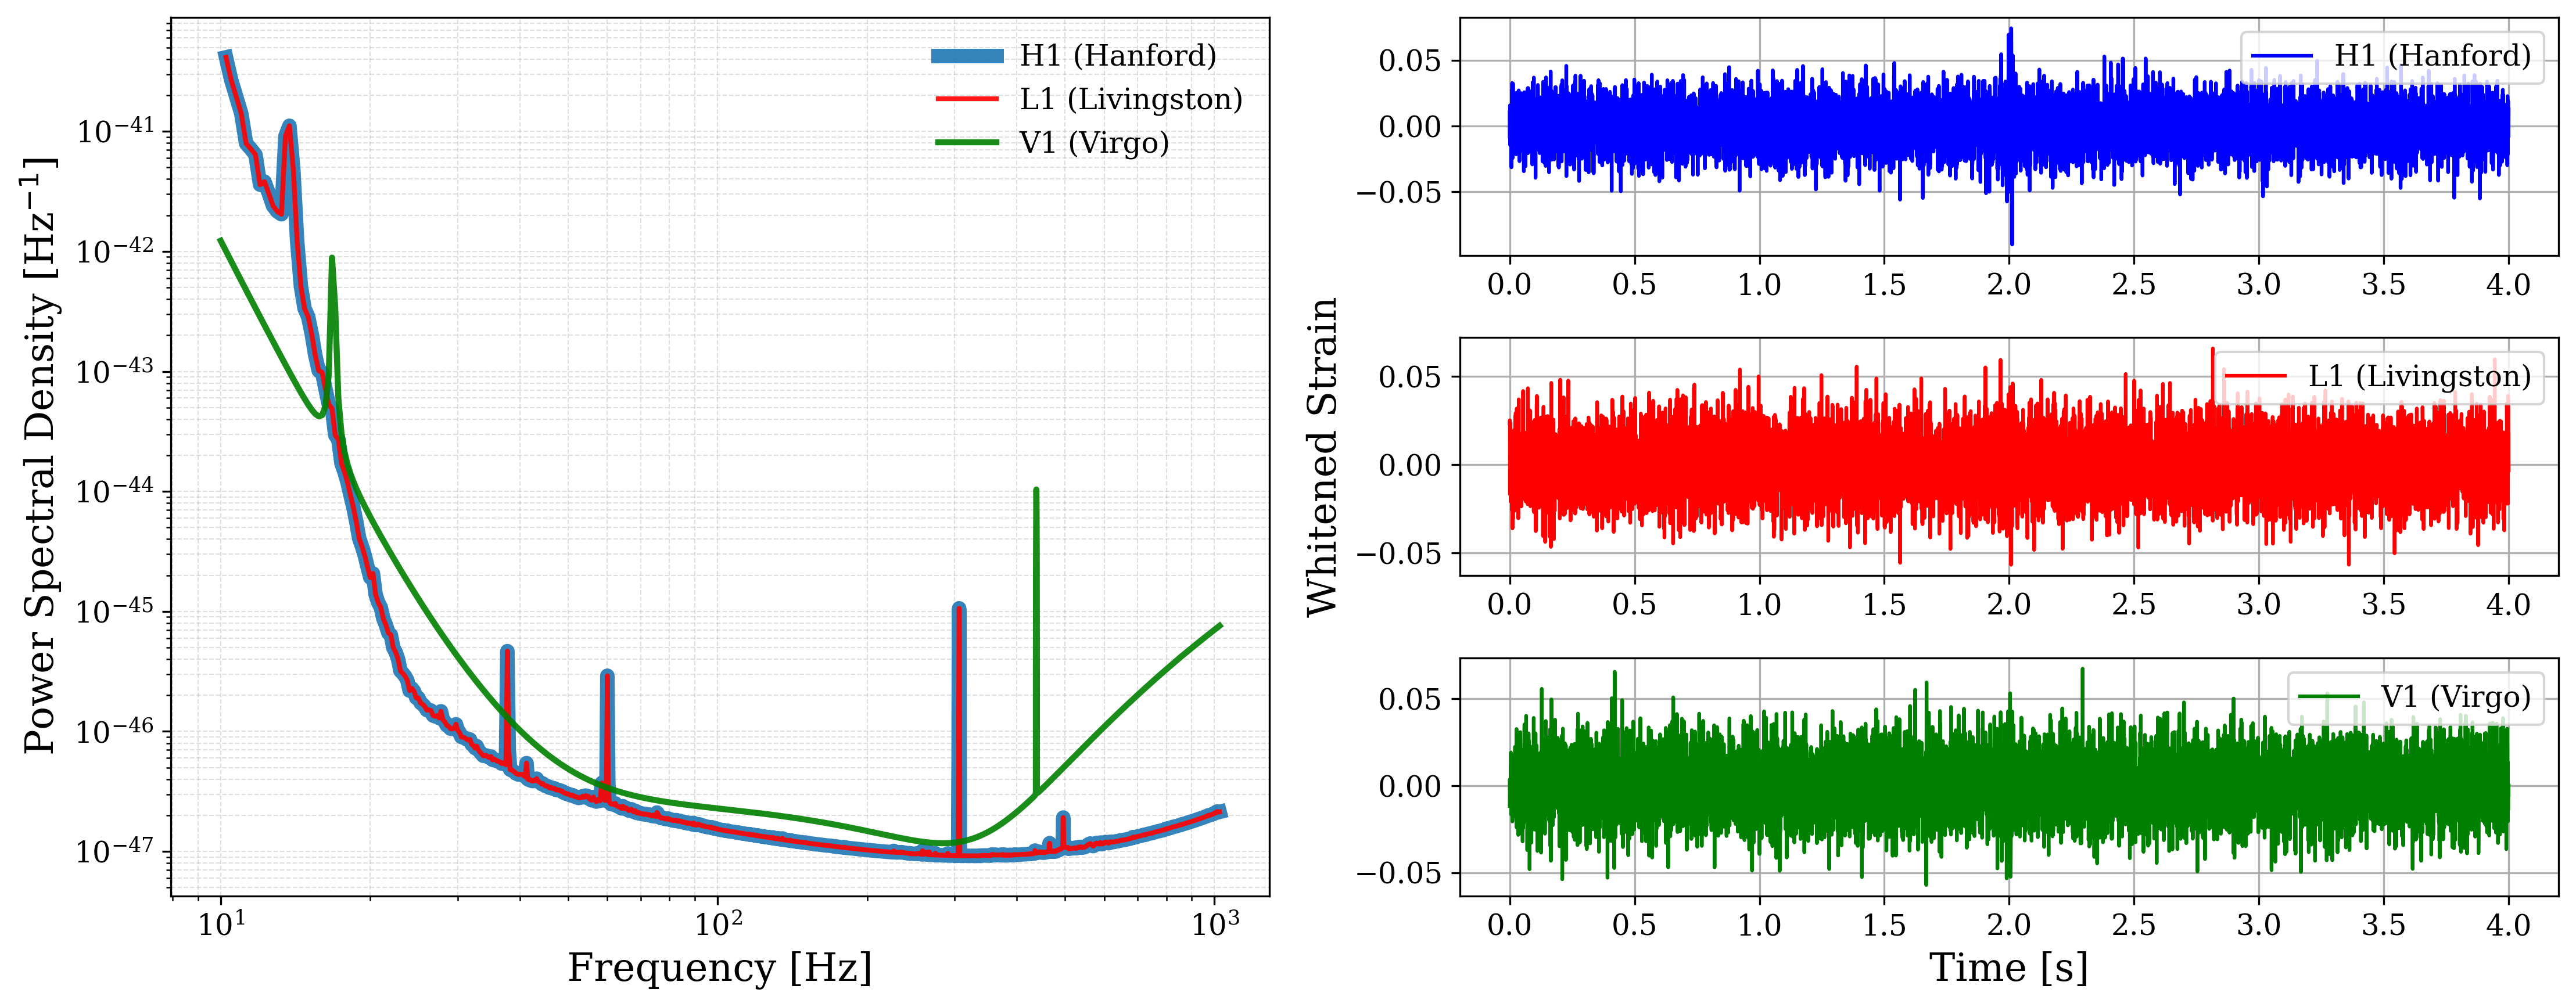

In [7]:
# Create the figure and a grid of subplots
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(3, 2) 

# PSD plot for each detector
ax_psd = fig.add_subplot(gs[:, 0]) # All rows, first column
ax_psd.loglog(H1_f_psd, H1_Sn, label="H1 (Hanford)", linewidth=6, alpha=0.9)
ax_psd.loglog(L1_f_psd, L1_Sn, label="L1 (Livingston)", linewidth=2, alpha=0.9, color = 'red')
ax_psd.loglog(V1_f_psd, V1_Sn, label="V1 (Virgo)", linewidth=2.5, alpha=0.9, color = 'green')

ax_psd.set_xlabel(r"Frequency [Hz]")
ax_psd.set_ylabel(r"Power Spectral Density [Hz$^{-1}$]")
ax_psd.legend(frameon=False)
ax_psd.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)

# Whitened time-domain strain plots 
ax_H1_whitened = fig.add_subplot(gs[0, 1]) # First row, second column
ax_L1_whitened = fig.add_subplot(gs[1, 1], sharex=ax_H1_whitened) # Second row, second column, share x-axis
ax_V1_whitened = fig.add_subplot(gs[2, 1], sharex=ax_H1_whitened) # Third row, second column, share x-axis

# Hanford (H1) whitened strain plot
ax_H1_whitened.plot(plot_time, H1_whitened_time, color='blue', label='H1 (Hanford)')
ax_H1_whitened.legend(loc="upper right")
ax_H1_whitened.grid(True)

# Livingston (L1) whitened strain plots
ax_L1_whitened.plot(plot_time, L1_whitened_time, color='red', label='L1 (Livingston)')
ax_L1_whitened.set_ylabel("Whitened Strain")
ax_L1_whitened.legend(loc="upper right")
ax_L1_whitened.grid(True)

# Virgo (V1) whitened strain plots
ax_V1_whitened.plot(plot_time, V1_whitened_time, color='green', label='V1 (Virgo)')
ax_V1_whitened.set_xlabel("Time [s]")
ax_V1_whitened.legend(loc="upper right")
ax_V1_whitened.grid(True)

plt.tight_layout()
plt.show()

## **Load the Waveform**

In [8]:
# --- Load waveform template ---
f_wave, hplus_real, hplus_imag, hcross_real, hcross_imag = np.loadtxt("data/Waveform/waveform.txt", unpack=True)
h_plus = hplus_real + 1j * hplus_imag
h_cross = hcross_real + 1j * hcross_imag

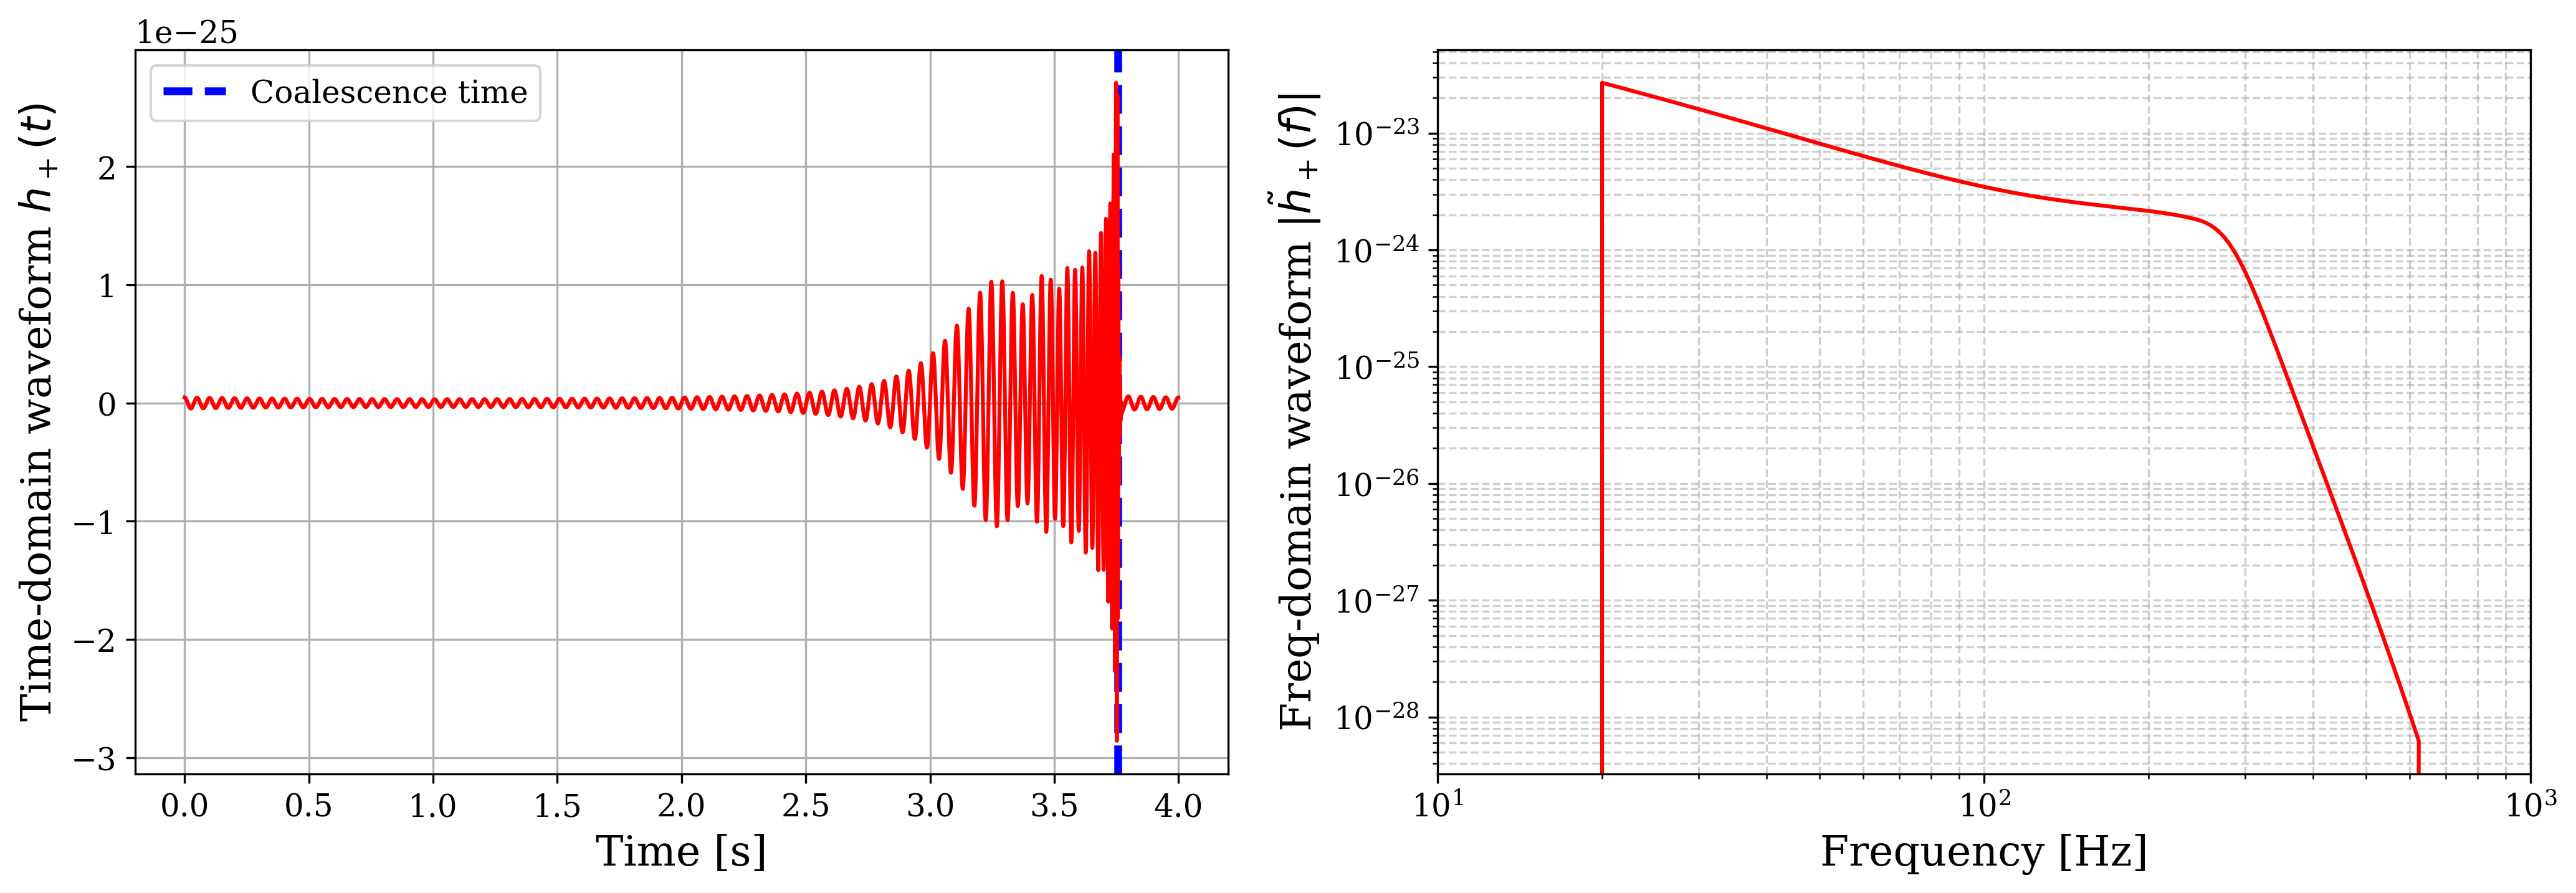

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Time-domain plot ---
h_plus_time = np.fft.irfft(h_plus)
axs[0].axvline(plot_time[-500], color='blue', linestyle='--', linewidth=3, label="Coalescence time")
axs[0].plot(plot_time, np.roll(h_plus_time, -500), color='red')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'Time-domain waveform $h_+(t)$')
axs[0].legend()
axs[0].grid(True)

# --- Frequency-domain plot ---
axs[1].loglog(f_wave, np.abs(h_plus), color='red')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel(r'Freq-domain waveform $|\tilde{h}_+(f)|$')
axs[1].set_xlim(10, 1000)
axs[1].grid(True, which='both', ls='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **Antenna Response Function**
As we do not know the position in the sky, the antenna function cannot be used at this point!

Typically the antenna function, describe the detector arms response to a gravitational wave depends on the position of the source in the sky (given by right ascension and declination) and the detector orientation.

This given in: 
$$
\tilde{h}_\text{det}(f) = F_+(f) \tilde{h}_+(f) + F_\times(f) \tilde{h}_\times(f)
$$

where:
- $F_+(f)$ and $F_\times(f)$ are the antenna pattern functions for the “plus” and “cross” polarizations, respectively.

### **Approach 1:**
- Use only $h_+(f)$ or only $h_\times(f)$ for matched filtering at a time
- Equivelent of setting the antenna response functions to:

#### Peak and Timing Information

| Case      |                      |   |
|-------------------------------|-------------|-----------------------|
| Using $\tilde{h}_+(f)$ | $F_+(f)$ = 1 | $F_x(f)$ = 0 |
| Using $\tilde{h}_x(f)$ | $F_+(f)$ = 0 | $F_x(f)$ = 1 |


In [10]:
# Apply matched filter using plus polarization waveform
rhosq_H1_plus = 4 * np.fft.irfft(H1_strain * np.conj(h_plus) / H1_Sn) * sampling_frequency
rhosq_L1_plus = 4 * np.fft.irfft(L1_strain * np.conj(h_plus) / L1_Sn) * sampling_frequency
rhosq_V1_plus = 4 * np.fft.irfft(V1_strain * np.conj(h_plus) / V1_Sn) * sampling_frequency

# Apply matched filter using cross polarization waveform 
rhosq_H1_cross = 4 * np.fft.irfft(H1_strain * np.conj(h_cross) / H1_Sn) * sampling_frequency
rhosq_L1_cross = 4 * np.fft.irfft(L1_strain * np.conj(h_cross) / L1_Sn) * sampling_frequency
rhosq_V1_cross = 4 * np.fft.irfft(V1_strain * np.conj(h_cross) / V1_Sn) * sampling_frequency

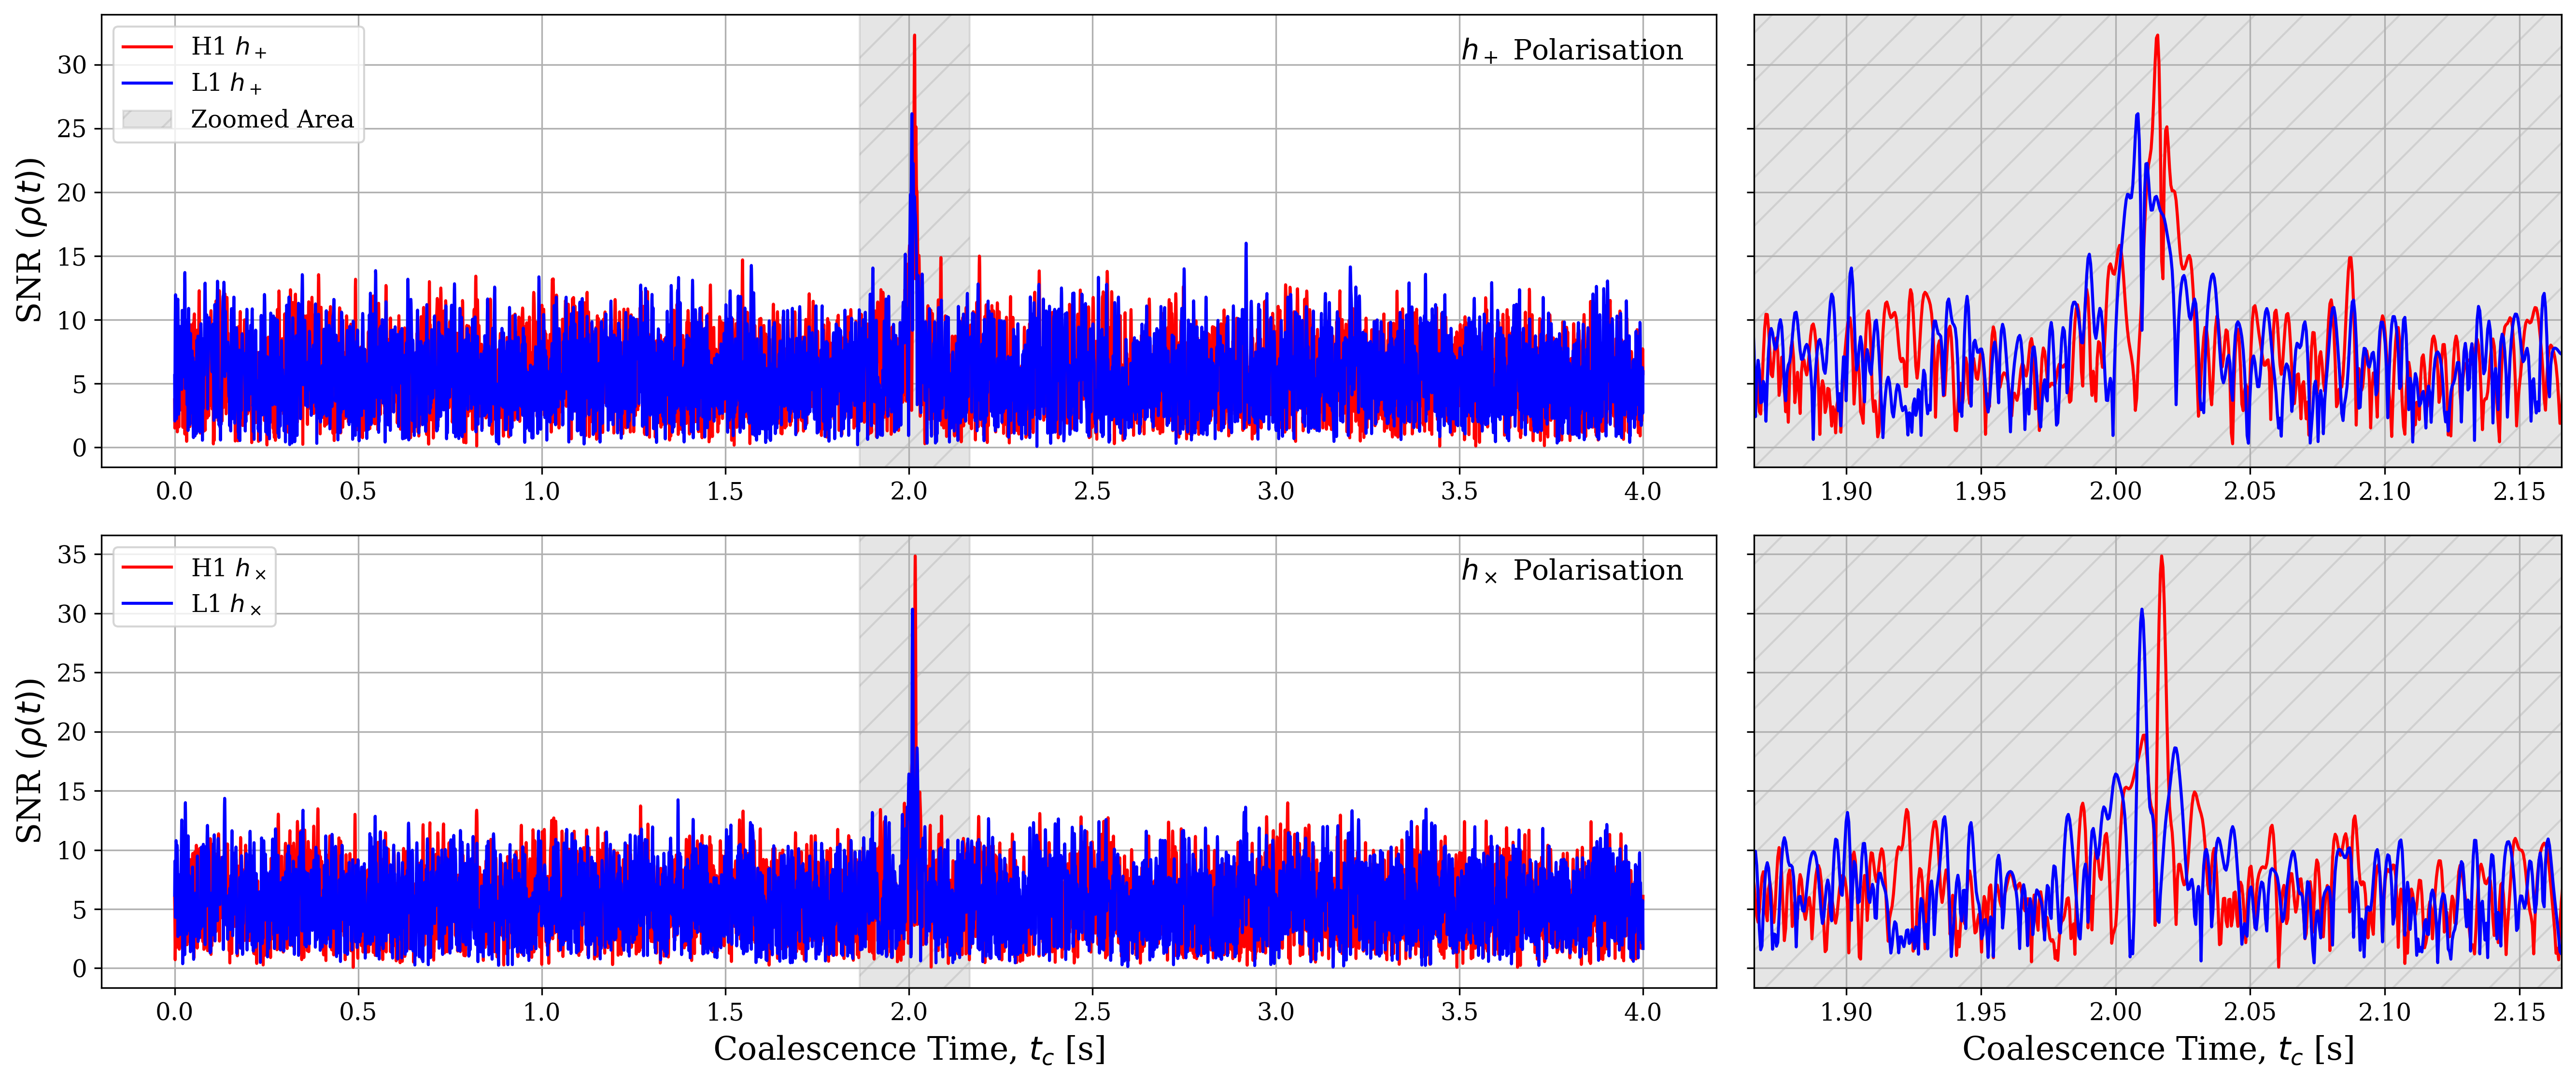

Maximum SNR values and corresponding times:
H1 h_+     : SNR = 32.31 at t = 2.015625 s
L1 h_+     : SNR = 26.15 at t = 2.008301 s
H1 h_x     : SNR = 34.85 at t = 2.017090 s
L1 h_x     : SNR = 30.36 at t = 2.009766 s


In [11]:
combined_abs_snr_plus = np.maximum(np.abs(rhosq_H1_plus), np.abs(rhosq_L1_plus))
max_abs_snr_index = np.argmax(combined_abs_snr_plus)
zoom_center_time = plot_time[max_abs_snr_index]

# Convert the matched filter rho^(t) values to SNR by taking square root of the absolute values
SNR_H1_plus = np.sqrt(np.abs(rhosq_H1_plus))
SNR_L1_plus = np.sqrt(np.abs(rhosq_L1_plus))
SNR_H1_cross = np.sqrt(np.abs(rhosq_H1_cross))
SNR_L1_cross = np.sqrt(np.abs(rhosq_L1_cross))

# Calculate the overall time range of the plot
overall_plot_range = plot_time.max() - plot_time.min()
# Create the zoomed-in range around the center time
zoom_duration = 0.075 * overall_plot_range 
zoom_start = zoom_center_time - zoom_duration / 2
zoom_end = zoom_center_time + zoom_duration / 2
zoom_start = max(zoom_start, plot_time.min())
zoom_end = min(zoom_end, plot_time.max())

# Plotting the main figure
fig = plt.figure(figsize=(18, 8)) 
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1]) 

# Left Column: Full View (
# h_plus polarisation matched filter results
ax_plus_full = fig.add_subplot(gs[0, 0])
ax_plus_full.plot(plot_time, SNR_H1_plus, label="H1 $h_+$", color='red')
ax_plus_full.plot(plot_time, SNR_L1_plus, label="L1 $h_+$", color='blue')
ax_plus_full.set_ylabel(r"SNR ($\rho(t)$)") 
ax_plus_full.legend()
ax_plus_full.grid(True)
ax_plus_full.text(0.98, 0.95, r"$h_+$ Polarisation", transform=ax_plus_full.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right')

# h_cross polarisation matched filter results
ax_cross_full = fig.add_subplot(gs[1, 0], sharex=ax_plus_full) # Share x-axis with the h_plus full view
ax_cross_full.plot(plot_time, SNR_H1_cross, label="H1 $h_\\times$", color='red')
ax_cross_full.plot(plot_time, SNR_L1_cross, label="L1 $h_\\times$", color='blue')
ax_cross_full.set_xlabel(r"Coalescence Time, $t_c$ [s]")
ax_cross_full.set_ylabel(r"SNR ($\rho(t)$)") # Primary Y-label for this row
ax_cross_full.legend()
ax_cross_full.grid(True)
ax_cross_full.text(0.98, 0.95, r"$h_\times$ Polarisation", transform=ax_cross_full.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right')

# Add a rectangle to the full view plots to show the zoomed area
ax_plus_full.axvspan(zoom_start, zoom_end, color='gray', alpha=0.2, hatch='/', label='Zoomed Area')
ax_plus_full.legend(loc='upper left')
ax_cross_full.axvspan(zoom_start, zoom_end, color='gray', alpha=0.2, hatch='/')


# --- Right Column: Zoomed-in View (Shares Y-axis with left) ---
# h_plus zoomed view
# sharey=ax_plus_full links the Y-axis limits and ticks with ax_plus_full.
ax_plus_zoom = fig.add_subplot(gs[0, 1], sharey=ax_plus_full)
ax_plus_zoom.plot(plot_time, SNR_H1_plus, label="H1 $h_+$", color='red')
ax_plus_zoom.plot(plot_time, SNR_L1_plus, label="L1 $h_+$", color='blue')
ax_plus_zoom.set_xlim(zoom_start, zoom_end)
# Removed set_ylabel as Y-axis is shared, label comes from ax_plus_full
ax_plus_zoom.tick_params(labelleft=False) # Hide y-tick labels for clarity, as they are shared
ax_plus_zoom.grid(True)
ax_plus_zoom.axvspan(zoom_start, zoom_end, color='gray', alpha=0.2, hatch='/', label='Zoomed Area')

# h_cross zoomed view
# sharey=ax_cross_full links the Y-axis limits and ticks with ax_cross_full.
ax_cross_zoom = fig.add_subplot(gs[1, 1], sharex=ax_plus_zoom, sharey=ax_cross_full)
ax_cross_zoom.plot(plot_time, SNR_H1_cross, label="H1 $h_\\times$", color='red')
ax_cross_zoom.plot(plot_time, SNR_L1_cross, label="L1 $h_\\times$", color='blue')
ax_cross_zoom.set_xlim(zoom_start, zoom_end)
ax_cross_zoom.set_xlabel(r"Coalescence Time, $t_c$ [s]")
# Removed set_ylabel as Y-axis is shared, label comes from ax_cross_full
ax_cross_zoom.tick_params(labelleft=False) # Hide y-tick labels for clarity, as they are shared
ax_cross_zoom.grid(True)
ax_cross_zoom.axvspan(zoom_start, zoom_end, color='gray', alpha=0.2, hatch='/', label='Zoomed Area')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for the suptitle
plt.show()

# Compute max SNR and corresponding time for each detector and polarisation
max_H1_plus_idx = np.argmax(np.abs(rhosq_H1_plus))
max_L1_plus_idx = np.argmax(np.abs(rhosq_L1_plus))
max_H1_cross_idx = np.argmax(np.abs(rhosq_H1_cross))
max_L1_cross_idx = np.argmax(np.abs(rhosq_L1_cross))

print("Maximum SNR values and corresponding times:")
print(f"H1 h_+     : SNR = {np.sqrt(np.abs(rhosq_H1_plus[max_H1_plus_idx])):.2f} at t = {plot_time[max_H1_plus_idx]:.6f} s")
print(f"L1 h_+     : SNR = {np.sqrt(np.abs(rhosq_L1_plus[max_L1_plus_idx])):.2f} at t = {plot_time[max_L1_plus_idx]:.6f} s")
print(f"H1 h_x     : SNR = {np.sqrt(np.abs(rhosq_H1_cross[max_H1_cross_idx])):.2f} at t = {plot_time[max_H1_cross_idx]:.6f} s")
print(f"L1 h_x     : SNR = {np.sqrt(np.abs(rhosq_L1_cross[max_L1_cross_idx])):.2f} at t = {plot_time[max_L1_cross_idx]:.6f} s")

### **Approach 2 (Grid of Ra and Dec):**
- Use a grid of Ra and Dec Positions and calculate their respective antenna functions
- Use the resultant functions to create a matched filtering template 
- Pass each match filtering over and determine peak SNR or $|\rho^2(t)|$
- This is the most likley match and should be used to give most accurate SNR and FWHM

- This proccess is automated within the function `optimise_matched_filtering`

In [12]:
?optimise_matched_filter

Signature:
optimise_matched_filter(
    detector,
    detector_strain,
    detector_psd,
    h_plus,
    h_cross,
    sampling_frequency,
    ra_range,
    dec_range,
    psi_range,
    n_samples,
    gps_start_time,
    plot_times,
)
Docstring:
Perform a grid search over (RA, Dec, Psi) sky locations and polarization angles to 
find the maximum matched filter SNR using a given waveform template.

We ensure to sample from Declination values uniformly on the sphere, which is done by 
sampling the sine of the declination angle. We also ignore the effects of time and do not
optimise for this as the effects are negligible over the 4 second duration of the signal.

This function computes the antenna pattern response for a given detector and
set of sky positions, constructs the corresponding waveform projection using
the plus and cross polarizations, and applies matched filtering in the 
frequency domain. The maximum time-domain SNR is extracted from the inverse 
Fourier transform of the matc

In [13]:
# Define ranges in radians
ra_range = (0, 2 * np.pi)
dec_range = (-np.pi / 2, np.pi / 2)
psi_range = (0, np.pi)
n_samples = (10, 5, 5)

# Run this very brief optimisation for each detector
# H1 Detector Optimised Over
H1_max_snr, H1_best_params = optimise_matched_filter(detector='H1', detector_strain=H1_strain, detector_psd=H1_Sn, h_plus=h_plus, h_cross=h_cross,
    sampling_frequency=sampling_frequency, ra_range=ra_range, dec_range=dec_range, psi_range=psi_range, n_samples=n_samples, gps_start_time=gps_start_time, plot_times=plot_time)
# L1 Detector Optimised Over
L1_max_snr, L1_best_params = optimise_matched_filter(detector='L1', detector_strain=L1_strain, detector_psd=L1_Sn, h_plus=h_plus, h_cross=h_cross,
    sampling_frequency=sampling_frequency, ra_range=ra_range, dec_range=dec_range, psi_range=psi_range, n_samples=n_samples, gps_start_time=gps_start_time, plot_times=plot_time)
# V1 Detector Optimised Over
V1_max_snr, V1_best_params = optimise_matched_filter(detector='V1', detector_strain=V1_strain, detector_psd=V1_Sn, h_plus=h_plus, h_cross=h_cross,
    sampling_frequency=sampling_frequency, ra_range=ra_range, dec_range=dec_range, psi_range=psi_range, n_samples=n_samples, gps_start_time=gps_start_time, plot_times=plot_time)


Maximum Rho^2 found for Dector H1: 1182.4248372161794 occured at time 0.000 seconds from GPS start time 1126259460.4.
Best parameters for Dector H1: RA = 3.491, Dec = -0.524, Psi = 1.571
The standard deviation of the times at which the maximum SNR occurs is 0.001 seconds.
Maximum Rho^2 found for Dector L1: 881.5341465952795 occured at time 0.000 seconds from GPS start time 1126259460.4.
Best parameters for Dector L1: RA = 0.698, Dec = 0.524, Psi = 2.356
The standard deviation of the times at which the maximum SNR occurs is 0.001 seconds.
Maximum Rho^2 found for Dector V1: 522.9172556984449 occured at time 0.000 seconds from GPS start time 1126259460.4.
Best parameters for Dector V1: RA = 2.793, Dec = 0.524, Psi = 0.000
The standard deviation of the times at which the maximum SNR occurs is 0.001 seconds.


## **Now run it for optimised versions**

In [14]:
?matched_filter_optimised

Signature:
matched_filter_optimised(
    detector,
    detector_strain,
    detector_psd,
    h_plus,
    h_cross,
    sampling_frequency,
    injection_parameters,
    plot_time,
    plotting=True,
)
Docstring:
Perform matched filtering for a single gravitational-wave detector and waveform projection,
returning the peak SNR, time of peak, and associated timing uncertainty (FWHM).

The function computes the matched filter output by correlating the detector strain data
against a projected waveform template defined by given sky location and polarization 
parameters. It also estimates the uncertainty on the signal arrival time using the 
full-width at half-maximum (FWHM) of the SNR time series, with interpolation for precision.

If `plotting=True`, a two-panel figure is shown with the full and zoomed-in SNR time series
and visual markers for the SNR peak and FWHM region.

Parameters
----------
detector : str
    Name of the detector ('H1', 'L1', or 'V1').

detector_strain : array_like (co

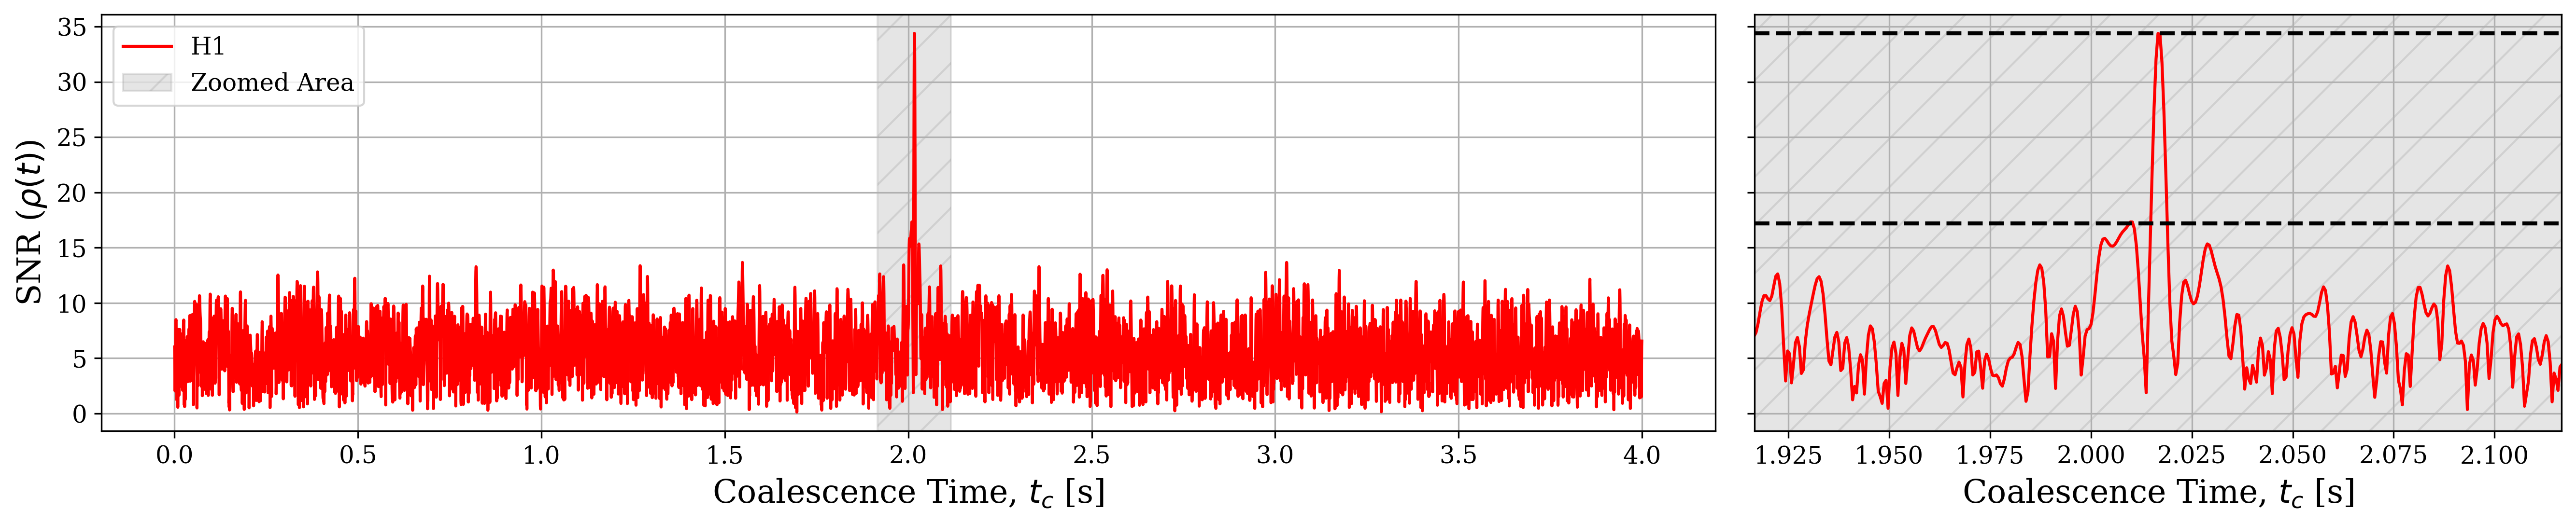

Maximum SNR for H1: 34.39 at time 2.016602 pm 0.002053 s


In [15]:
H1_max_snr, H1_time_max_snr, H1_time_uncertainty = matched_filter_optimised(detector='H1', detector_strain=H1_strain, detector_psd=H1_Sn, h_plus=h_plus, h_cross=h_cross, sampling_frequency=sampling_frequency, injection_parameters = H1_best_params ,plot_time=plot_time)

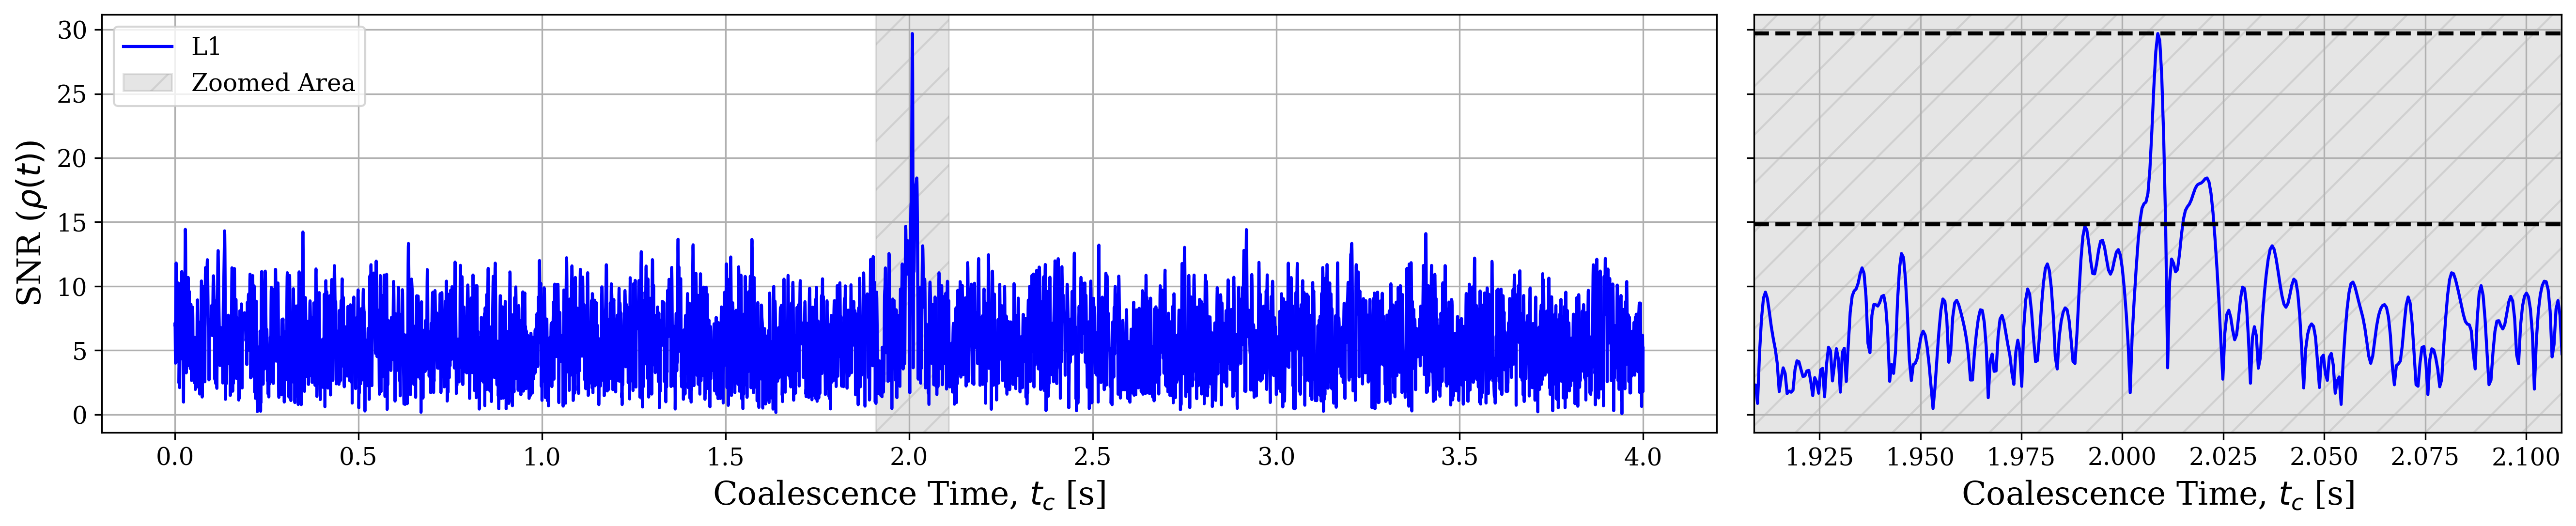

Maximum SNR for L1: 29.69 at time 2.008789 pm 0.003207 s


In [16]:
L1_max_snr, L1_time_max_snr, L1_time_uncertainty = matched_filter_optimised(detector='L1', detector_strain=L1_strain, detector_psd=L1_Sn, h_plus=h_plus, h_cross=h_cross, sampling_frequency=sampling_frequency, injection_parameters = L1_best_params ,plot_time=plot_time)

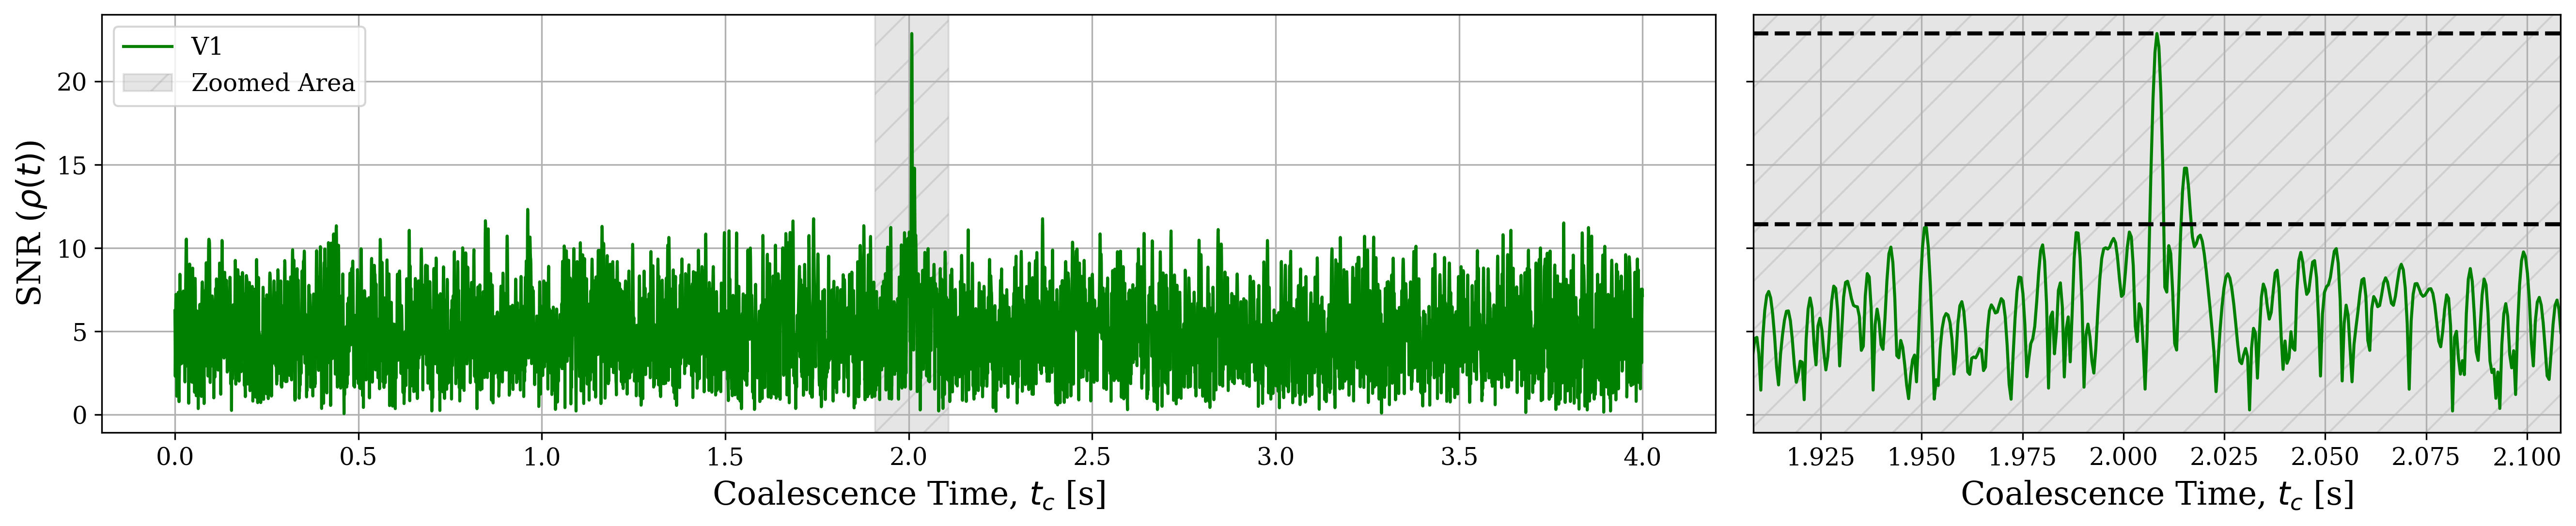

Maximum SNR for V1: 22.87 at time 2.008301 pm 0.001741 s


In [17]:
V1_max_snr, V1_time_max_snr, V1_time_uncertainty = matched_filter_optimised(detector='V1', detector_strain=V1_strain, detector_psd=V1_Sn, h_plus=h_plus, h_cross=h_cross, sampling_frequency=sampling_frequency, injection_parameters = V1_best_params, plot_time=plot_time)

## **Localisation of Source using time delay:**

We constrain the sky position ($\alpha$, $\delta$) using arrival time differences between two detectors under a Gaussian timing model.

Given arrival times $t_1$, $t_2$ with uncertainties $\sigma_1$, $\sigma_2$, the log-likelihood $\log \mathcal{L}(\alpha, \delta)$ is computed as:

$$
\log \mathcal{L}(\alpha, \delta) =
	-	\frac{1}{2} \left( \frac{\Delta t_{\text{obs}} - \Delta t_{\text{model}}(\alpha, \delta)}{\sigma} \right)^2
	- \frac{1}{2} \log(2\pi \sigma^2)
$$

with the following definitions:

Observed time difference:
$$
\Delta t_{\text{obs}} = t_1 - t_2
$$

Total uncertainty:
$$
\sigma^2 = \sigma_1^2 + \sigma_2^2
$$

Modeled time difference:
$$
\Delta t_{\text{model}}(\alpha, \delta) = \tau_1(\alpha, \delta) - \tau_2(\alpha, \delta)
$$

where $\tau_1(\alpha, \delta)$ and $\tau_2(\alpha, \delta)$ are the predicted time delays from the geocenter to detectors 1 and 2, respectively, for a source located at ($\alpha$, $\delta$).


In [83]:
def loglikelihood_delay(ra, dec, detectors = ['H1', 'L1'], arrival_times =[0, 0], arrival_time_uncert = [0.1, 0.1], gps_start_time = 0):
    """
    Compute the log-likelihood of a sky location (RA, Dec) given observed arrival 
    time differences between two detectors using a Gaussian timing model.

    Parameters
    ----------
    ra : float
        Right ascension of the source in radians.
    dec : float
        Declination of the source in radians.
    detectors : list of str
        List of two detector names (e.g., ['H1', 'L1']). Must be two of 'H1', 'L1', or 'V1'.
    arrival_times : list of float
        Measured arrival times (in seconds) at each detector (typically wrt GPS reference).
    arrival_time_uncert : list of float
        1-sigma uncertainties on the arrival times for each detector.
    gps_start_time : float
        Reference GPS time at which to compute time delays from the geocenter.

    Returns
    -------
    log_likelihood : float
        The log-likelihood of the input sky position under the observed time delay 
        using a Gaussian likelihood model.
    
    Notes
    -----
    The log-likelihood is computed as:
        logL = -0.5 * ((delta_t_obs - delta_t_model)^2 / sigma^2 + log(2π sigma^2))
    where:
        delta_t_obs = observed arrival time difference between detectors
        delta_t_model  = predicted time difference from the sky position
        sigma         = combined timing uncertainty (quadrature sum)
    """
    # Ensure that only two detectors are named and they are either H1, L1 or V1
    if len(detectors) != 2 or not all(detector in ['H1', 'L1', 'V1'] for detector in detectors):
        raise ValueError("Only two detectors are allowed, and they must be either 'H1', 'L1', or 'V1'.")
    
    # Ensure that arrival_times and arrival_time_uncert are lists of the same length as detectors
    if len(arrival_times) != len(detectors) or len(arrival_time_uncert) != len(detectors):
        raise ValueError("arrival_times and arrival_time_uncert must have the same length as detectors.")
    
    # Calculate the difference in arrival times with respective error
    delta_t_obs = arrival_times[0] - arrival_times[1]
    # Add errors in quadrature
    sigma = np.sqrt(arrival_time_uncert[0]**2 + arrival_time_uncert[1]**2) 

    # Calculate the expected time difference based on the sky location
    # Initialise the bilby interferometer objects
    interferometer_0 = bilby.gw.detector.InterferometerList([detectors[0]])[0]
    interferometer_1 = bilby.gw.detector.InterferometerList([detectors[1]])[0]

    # Expected time difference based on the sky location
    # We use the gps start time to calculate the time delay from the geocenter as over 4 seconds the time delay is constant
    time_delay_0 = interferometer_0.time_delay_from_geocenter(ra=ra, dec=dec, time = gps_start_time)
    time_delay_1 = interferometer_1.time_delay_from_geocenter(ra=ra, dec=dec, time = gps_start_time)
    delta_t_model = time_delay_0 - time_delay_1

    # Calculate the number of sigma errors 
    sigma_away = abs((delta_t_obs - delta_t_model) / sigma)

    # A gaussian likelihood is assumed with expected - mean and standard deviation as uncertainty
    log_likelihood = -0.5 * (((delta_t_obs - delta_t_model) / sigma)) ** 2

    return log_likelihood, sigma_away


def generate_likelihood_skymap(detectors, arrival_times, arrival_time_uncert, gps_start_time, n_ra=100, n_dec=50):
    """
    Generate and plot a sky localization likelihood map using Cartopy.

    Parameters
    ----------
    detectors : list of str
        List of detector names (e.g., ['H1', 'L1']).
    arrival_times : list of float
        Measured arrival times at each detector.
    arrival_time_uncert : list of float
        Timing uncertainties for each detector.
    gps_start_time : float
        GPS time to compute geocenter delays.
    n_ra : int
        Number of RA bins.
    n_dec : int
        Number of Dec bins.

    Returns
    -------
    delta_chi2 : ndarray
        The delta chi-square grid over (RA, Dec).
    """

    # Grid in RA [0, 2π] and Dec [-π/2, π/2] in radians
    ra = np.linspace(0, 2 * np.pi, n_ra)
    dec = np.linspace(-np.pi / 2, np.pi / 2, n_dec)
    RA, DEC = np.meshgrid(ra, dec)

    # Compute log-likelihood over grid
    logL_grid = np.zeros_like(RA)
    sigma_away = np.zeros_like(RA)

    for i in range(RA.shape[0]):
        for j in range(RA.shape[1]):
            logL_grid[i, j], sigma_away[i, j]= loglikelihood_delay( RA[i, j], DEC[i, j], detectors=detectors, arrival_times=arrival_times,
                arrival_time_uncert=arrival_time_uncert, gps_start_time=gps_start_time )

    return logL_grid, sigma_away




def plot_confidence_map(sigma_away, n_ra=100, n_dec=50):

    # Grid in RA [0, 2π] and Dec [-π/2, π/2] in radians
    ra = np.linspace(0, 2 * np.pi, n_ra)
    dec = np.linspace(-np.pi / 2, np.pi / 2, n_dec)
    RA, DEC = np.meshgrid(ra, dec)

    # Plotting with Cartopy
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.set_global()

    # Gridlines only (no coastlines or land)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

    # Plot filled contours
    levels = [1, 2, 3]  # 68%, 95%, 99.7% confidence for 2 DOF
    cf = ax.contourf(np.degrees(RA), -np.degrees(DEC), sigma_away,levels=levels, cmap='plasma', extend='max', transform=ccrs.PlateCarree())

    # Optional: Add contour lines on top of fill
    cs = ax.contour(np.degrees(RA), -np.degrees(DEC), sigma_away, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    
    # Title
    plt.title("Sky Localization via Timing Likelihood")
    plt.show()
    
    

In [74]:
# Example parameters
detectors_choice = ['H1', 'L1']
arrival_times_in = [H1_time_max_snr, L1_time_max_snr]
arrival_time_uncert_in = [H1_time_uncertainty, L1_time_uncertainty]

# Generate map
H1_L1_prob_map , H1_L1_sigma_map = generate_likelihood_skymap(detectors=detectors_choice, arrival_times = arrival_times_in, arrival_time_uncert = arrival_time_uncert_in, gps_start_time = gps_start_time)

In [75]:
# Example parameters
detectors_choice = ['V1', 'L1']
arrival_times_in = [V1_time_max_snr, L1_time_max_snr]
arrival_time_uncert_in = [V1_time_uncertainty, L1_time_uncertainty]

# Generate map
V1_L1_prob_map, V1_L1_sigma_map = generate_likelihood_skymap(detectors=detectors_choice, arrival_times = arrival_times_in, arrival_time_uncert = arrival_time_uncert_in, gps_start_time = gps_start_time)

In [ ]:
# Example parameters
detectors_choice = ['V1', 'H1']
arrival_times_in = [V1_time_max_snr, H1_time_max_snr]
arrival_time_uncert_in = [V1_time_uncertainty, H1_time_uncertainty]

# Generate map
V1_H1_prob_map, V1_H1_sigma_map = generate_likelihood_skymap(detectors=detectors_choice, arrival_times = arrival_times_in, arrival_time_uncert = arrival_time_uncert_in, gps_start_time = gps_start_time)

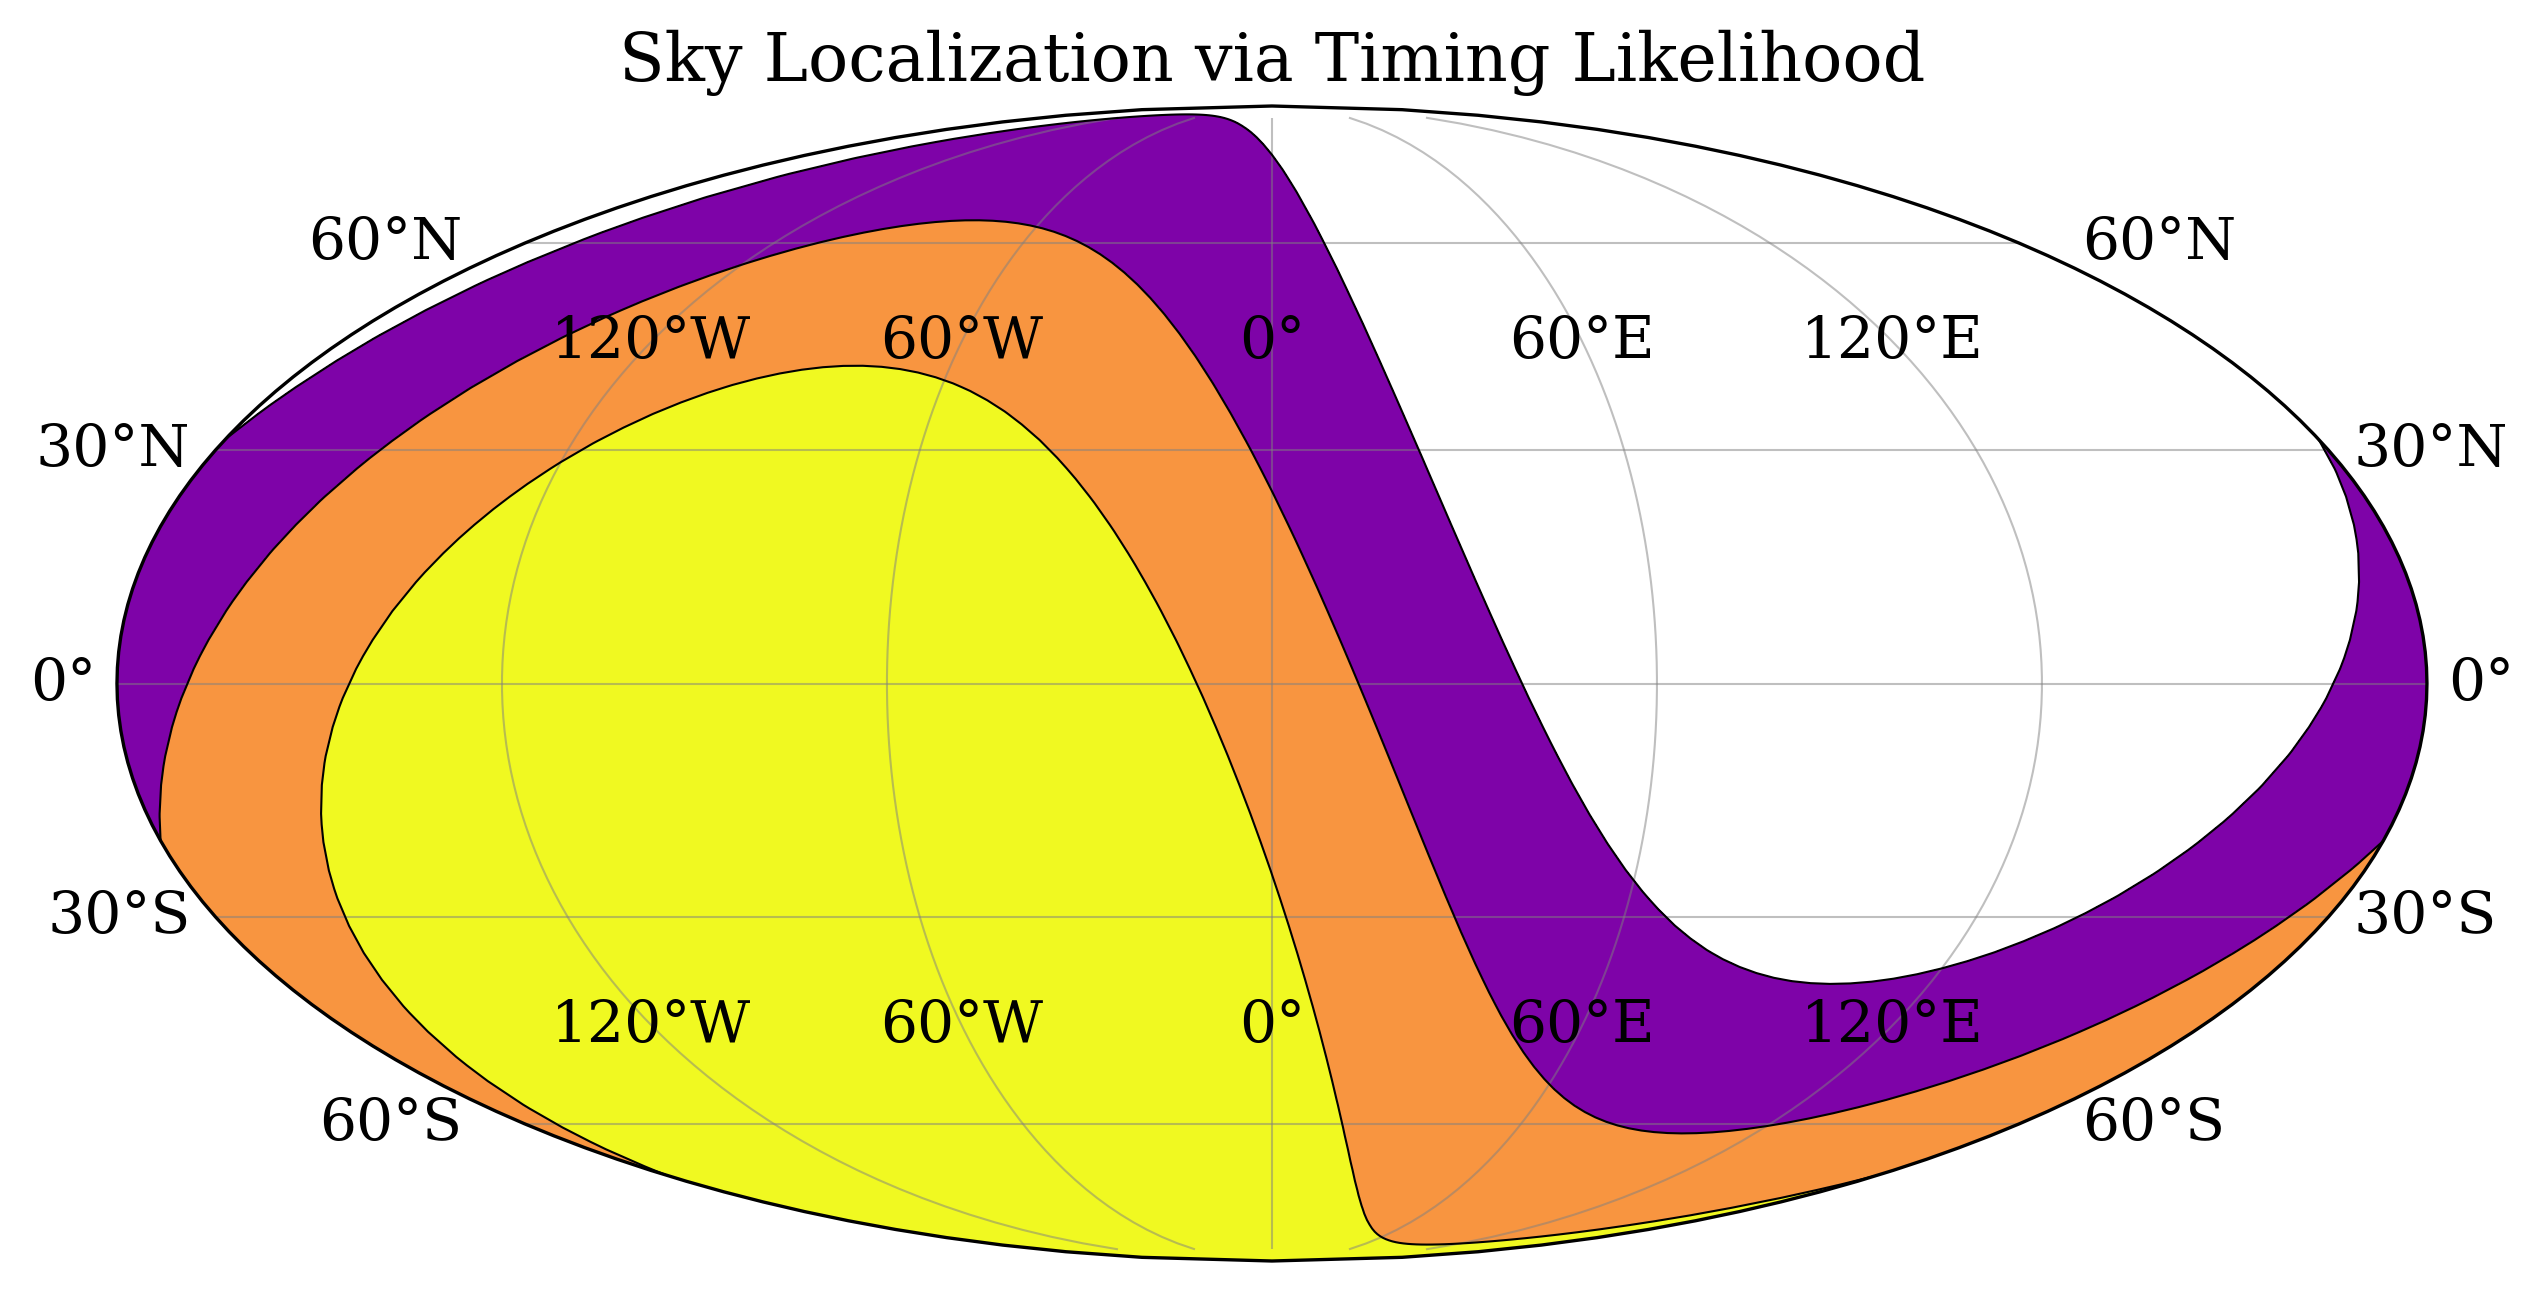

In [84]:
plot_confidence_map(H1_L1_sigma_map)

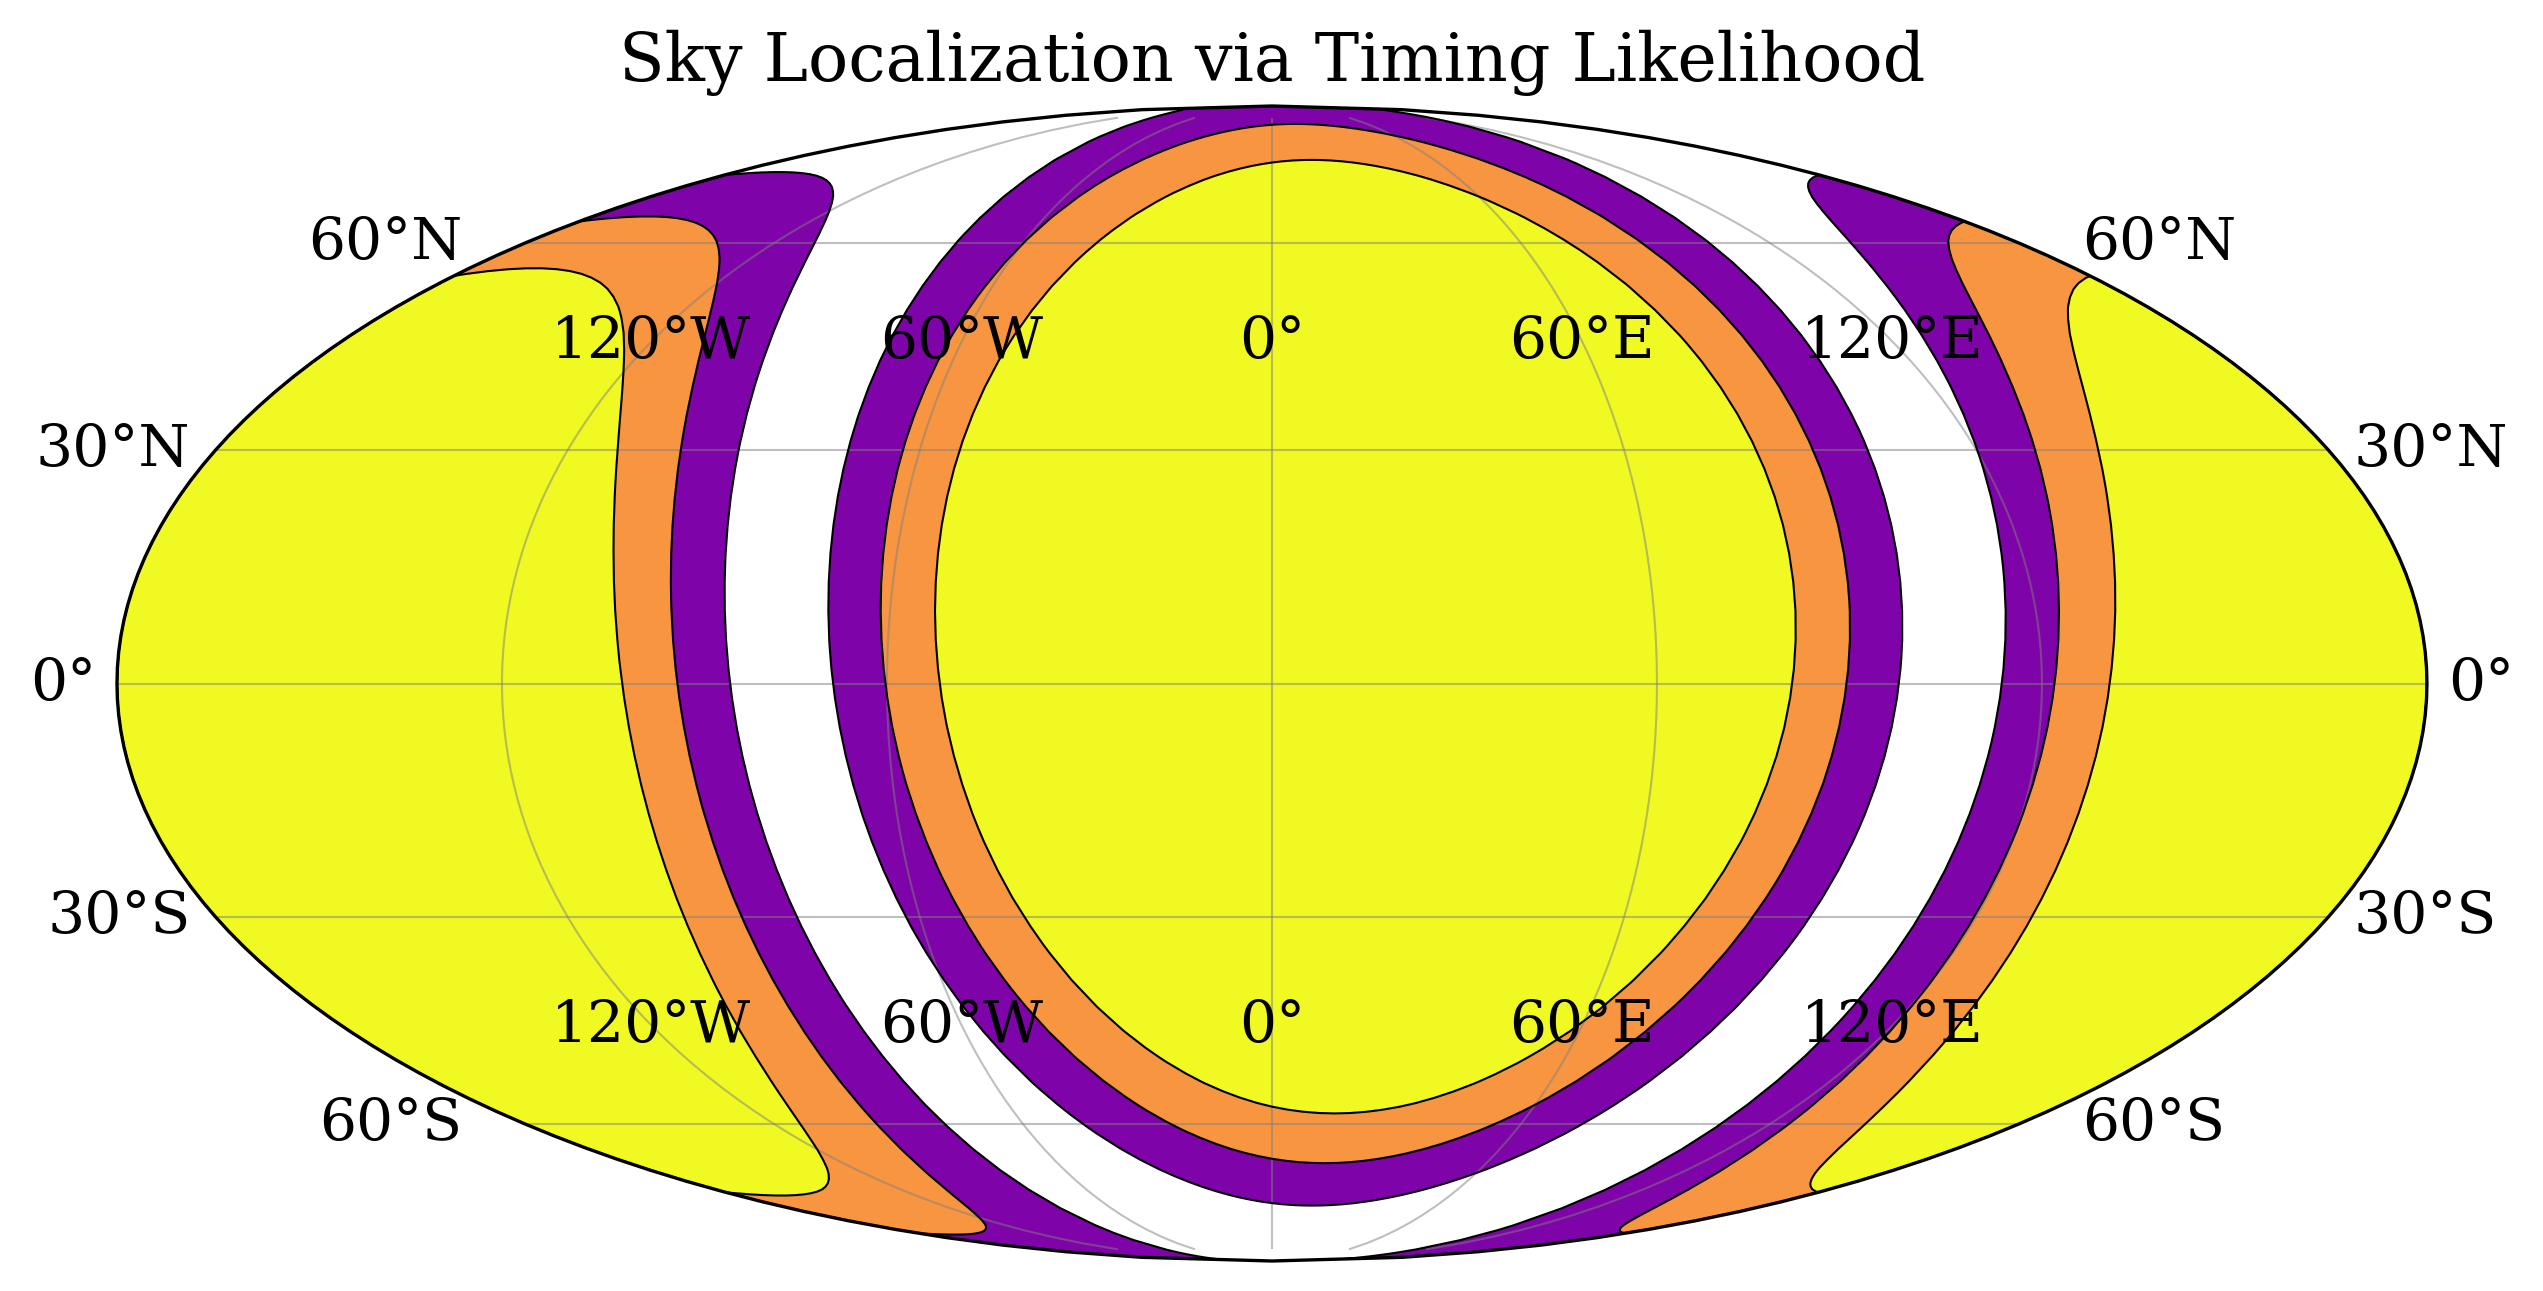

In [86]:
plot_confidence_map(V1_L1_sigma_map)

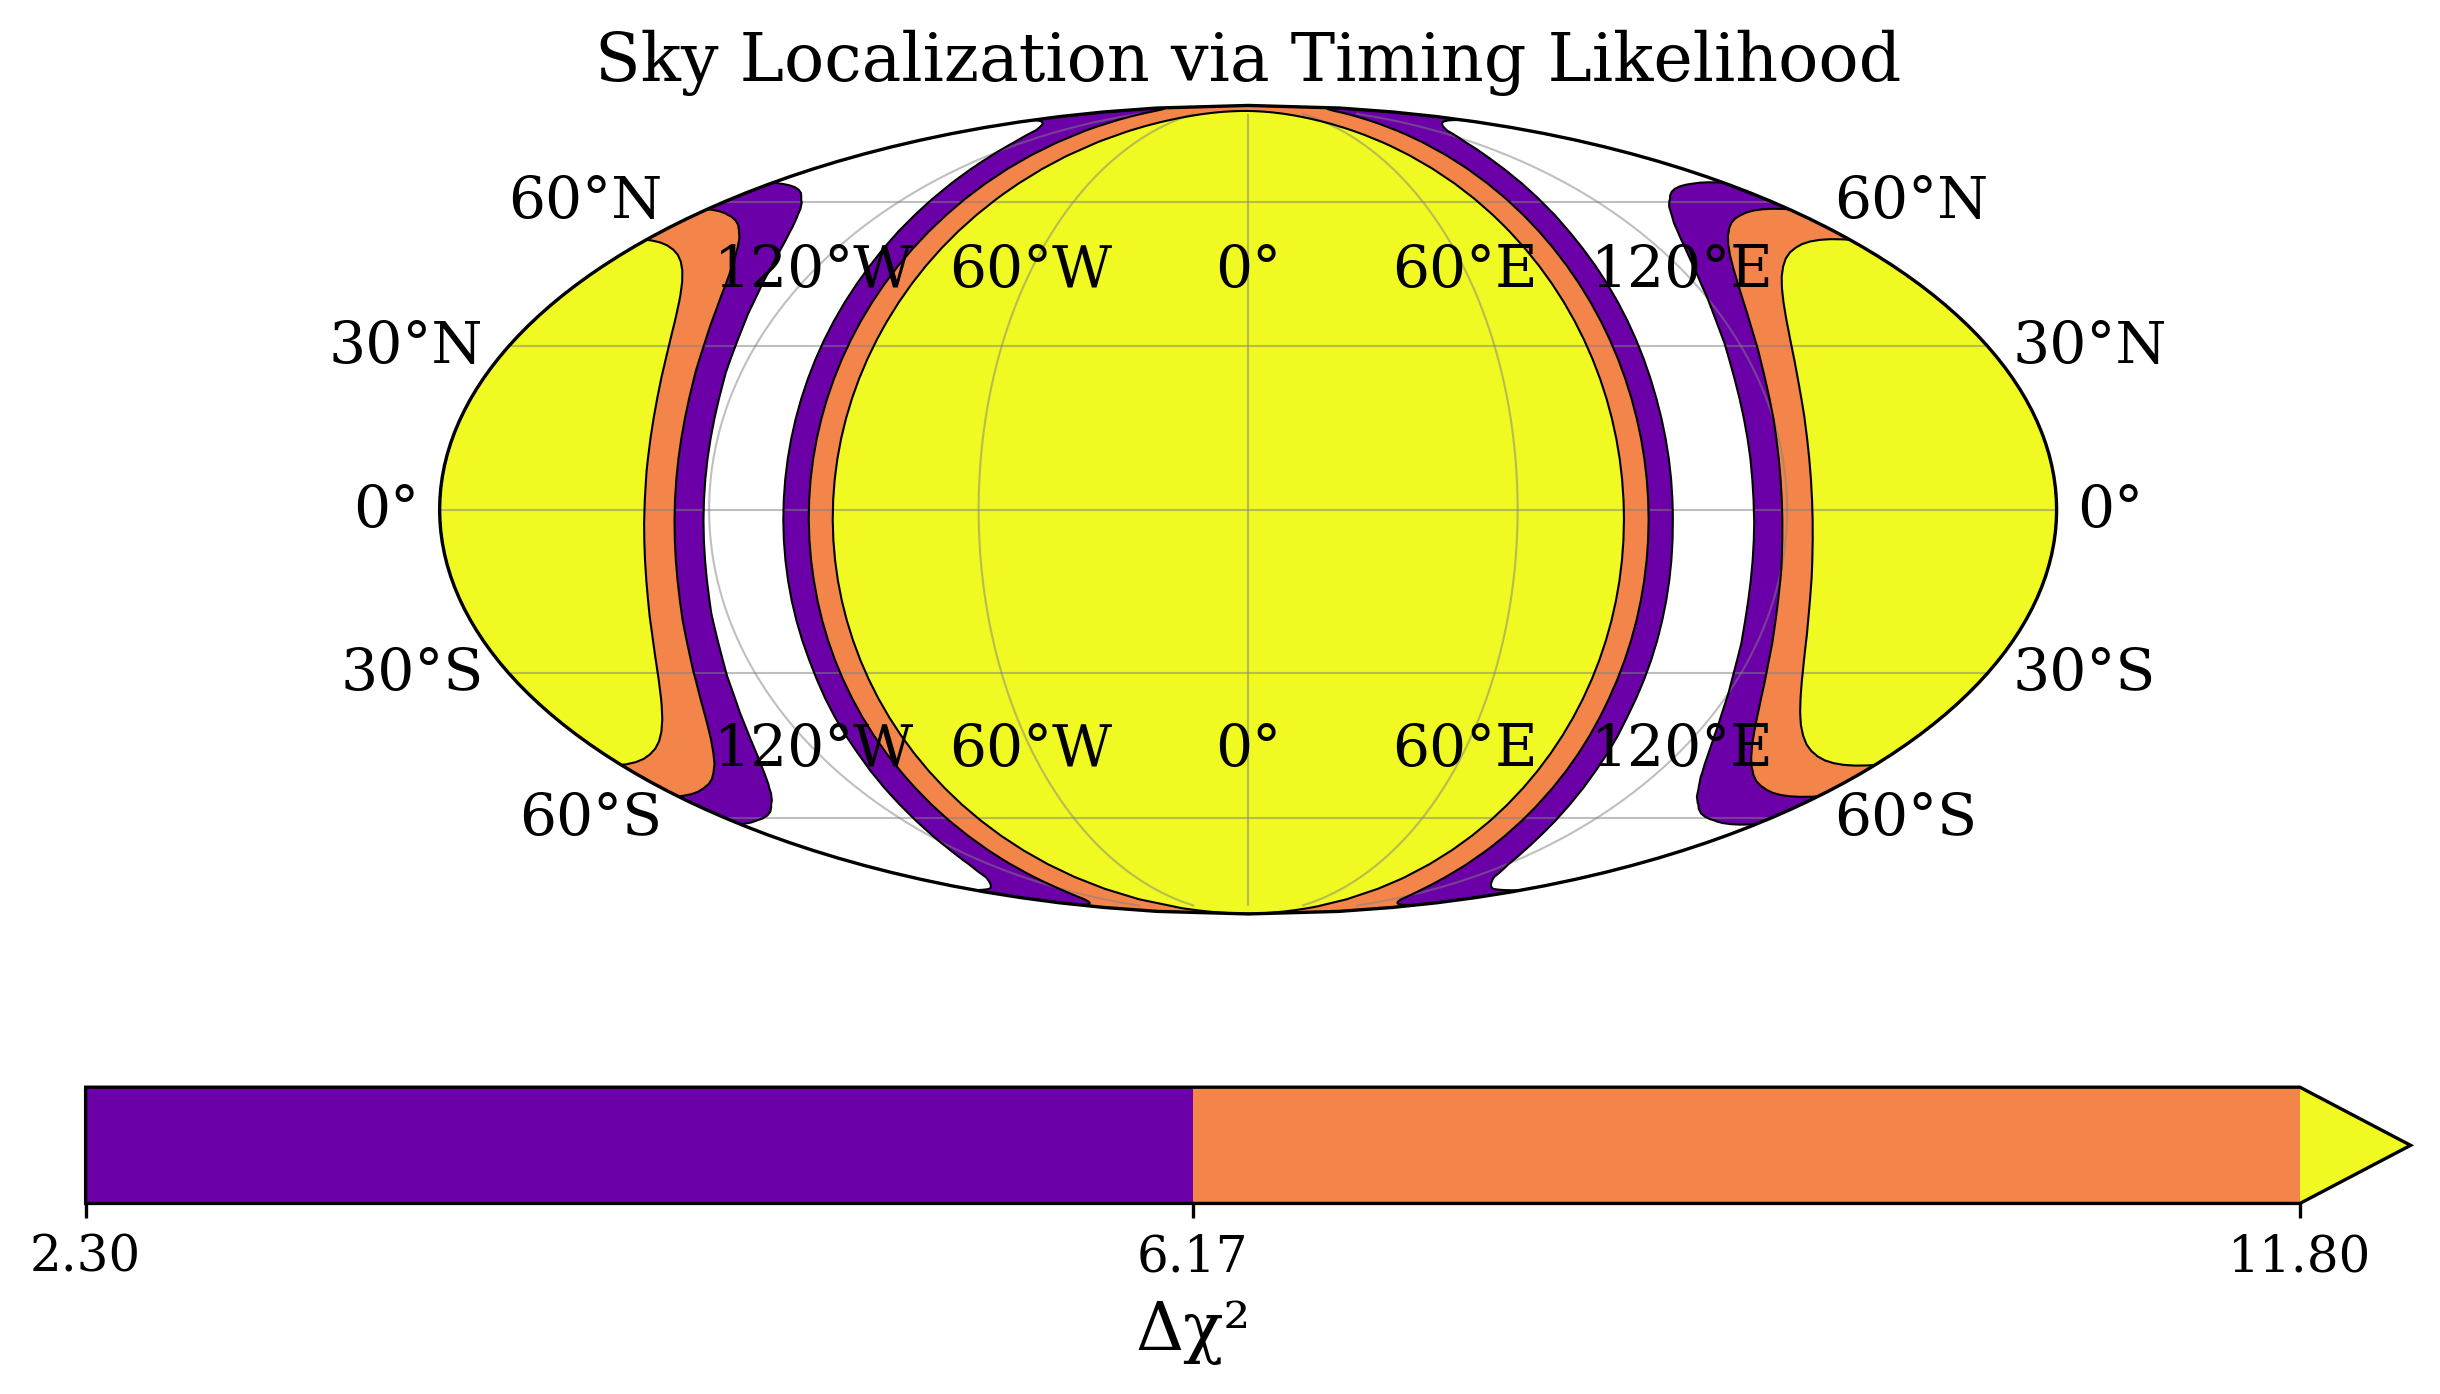

In [59]:
plot_confidence_map(V1_H1_prob_map)

In [ ]:
# Grid in RA [0, 2π] and Dec [-π/2, π/2] in radians
ra = np.linspace(0, 2 * np.pi, 100)
dec = np.linspace(-np.pi / 2, np.pi / 2, 50)
RA, DEC = np.meshgrid(ra, dec)



# Plotting with Cartopy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()

# Gridlines only (no coastlines or land)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# Plot filled contours
levels = [2.3, 6.17, 11.8]  # 68%, 95%, 99.7% confidence for 2 DOF
cf = ax.contourf(np.degrees(RA), -np.degrees(DEC), prob_map,
                 levels=levels, cmap='plasma', extend='max',
                 transform=ccrs.PlateCarree())

# Optional: Add contour lines on top of fill
cs = ax.contour(np.degrees(RA), -np.degrees(DEC), prob_map,
                levels=levels, colors='black', linewidths=0.5,
                transform=ccrs.PlateCarree())

# Label contour lines
fmt = {l: f"{p}%" for l, p in zip(levels, [68, 95, 99.7])}
ax.clabel(cs, fmt=fmt, fontsize=10)

# Title
plt.title("Sky Localization via Timing Likelihood")
plt.colorbar(cf, ax=ax, orientation='horizontal', label='Δχ²')
plt.show()

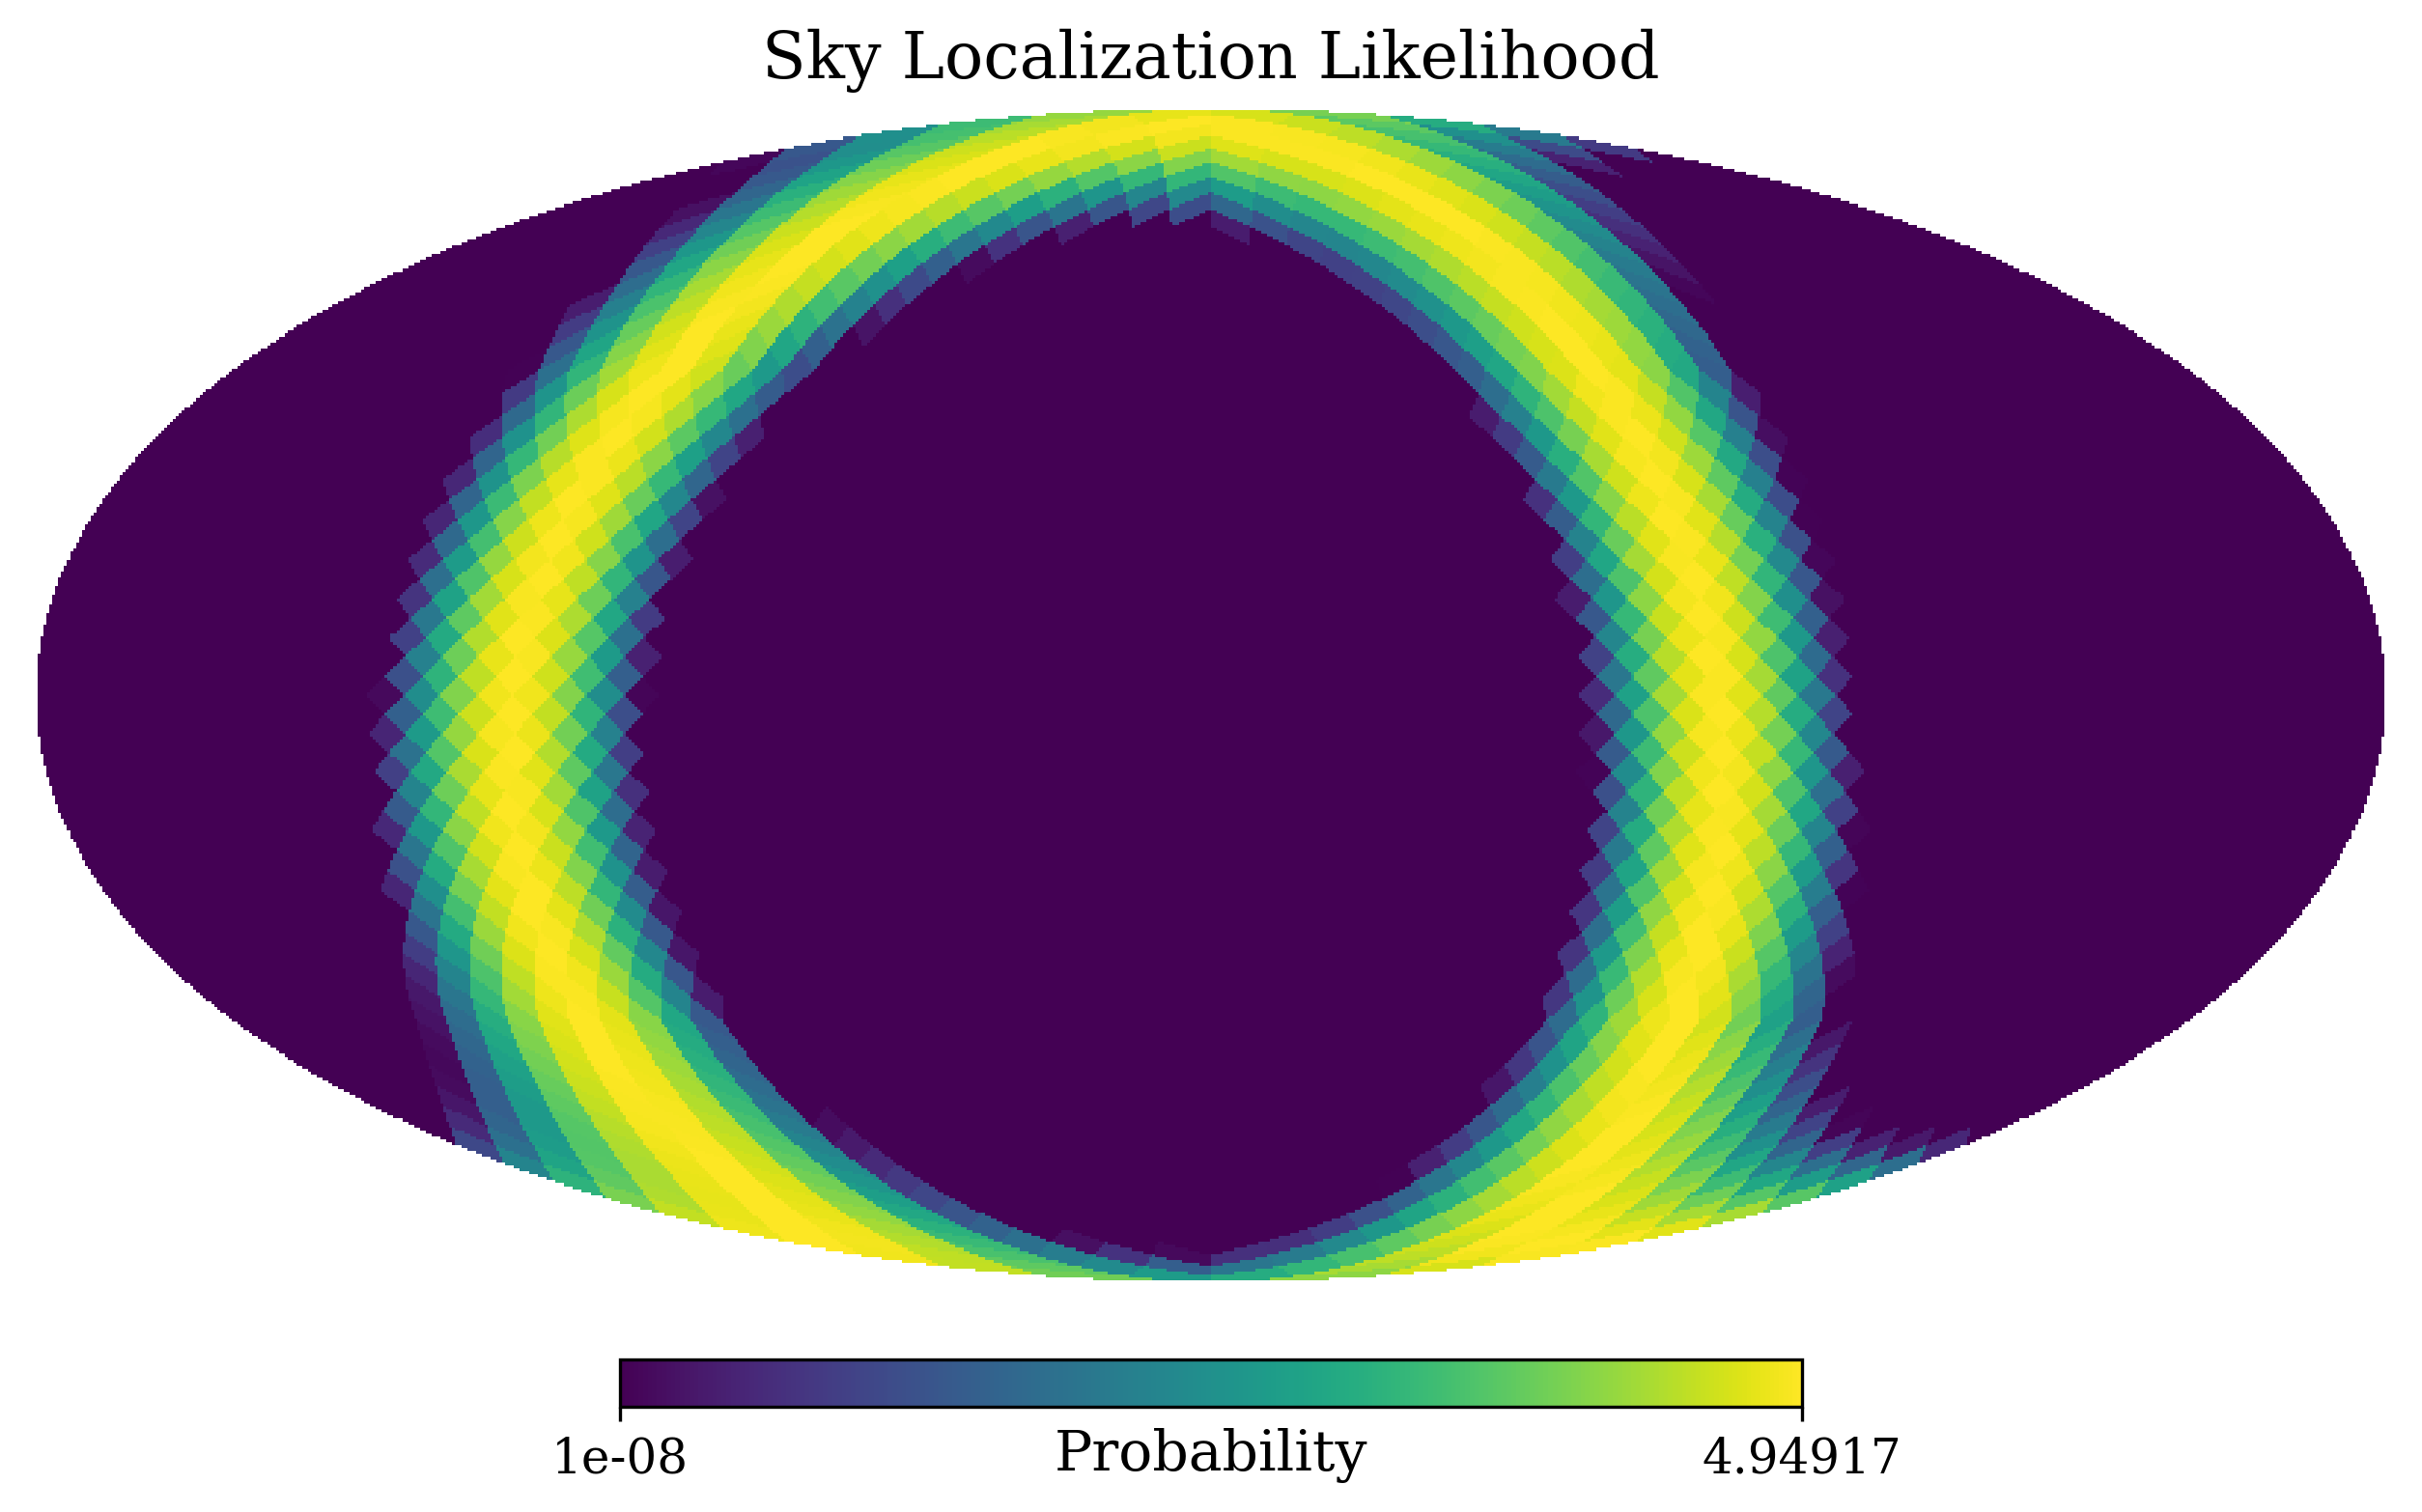

: 

: 

: 

In [ ]:
# Example parameters
nside = 16
detectors_choice = ['V1', 'L1']
arrival_times_in = [V1_time_max_snr, L1_time_max_snr]
arrival_time_uncert_in = [V1_time_uncertainty, L1_time_uncertainty]

# Generate map
prob_map = generate_likelihood_skymap(nside, detectors=detectors_choice, arrival_times = arrival_times_in, arrival_time_uncert = arrival_time_uncert_in, gps_start_time = gps_start_time)
# Plot the probability map
hp.mollview(prob_map, title='Sky Localization Likelihood', unit='Probability',
            cmap='viridis', min=1e-8)
plt.show()

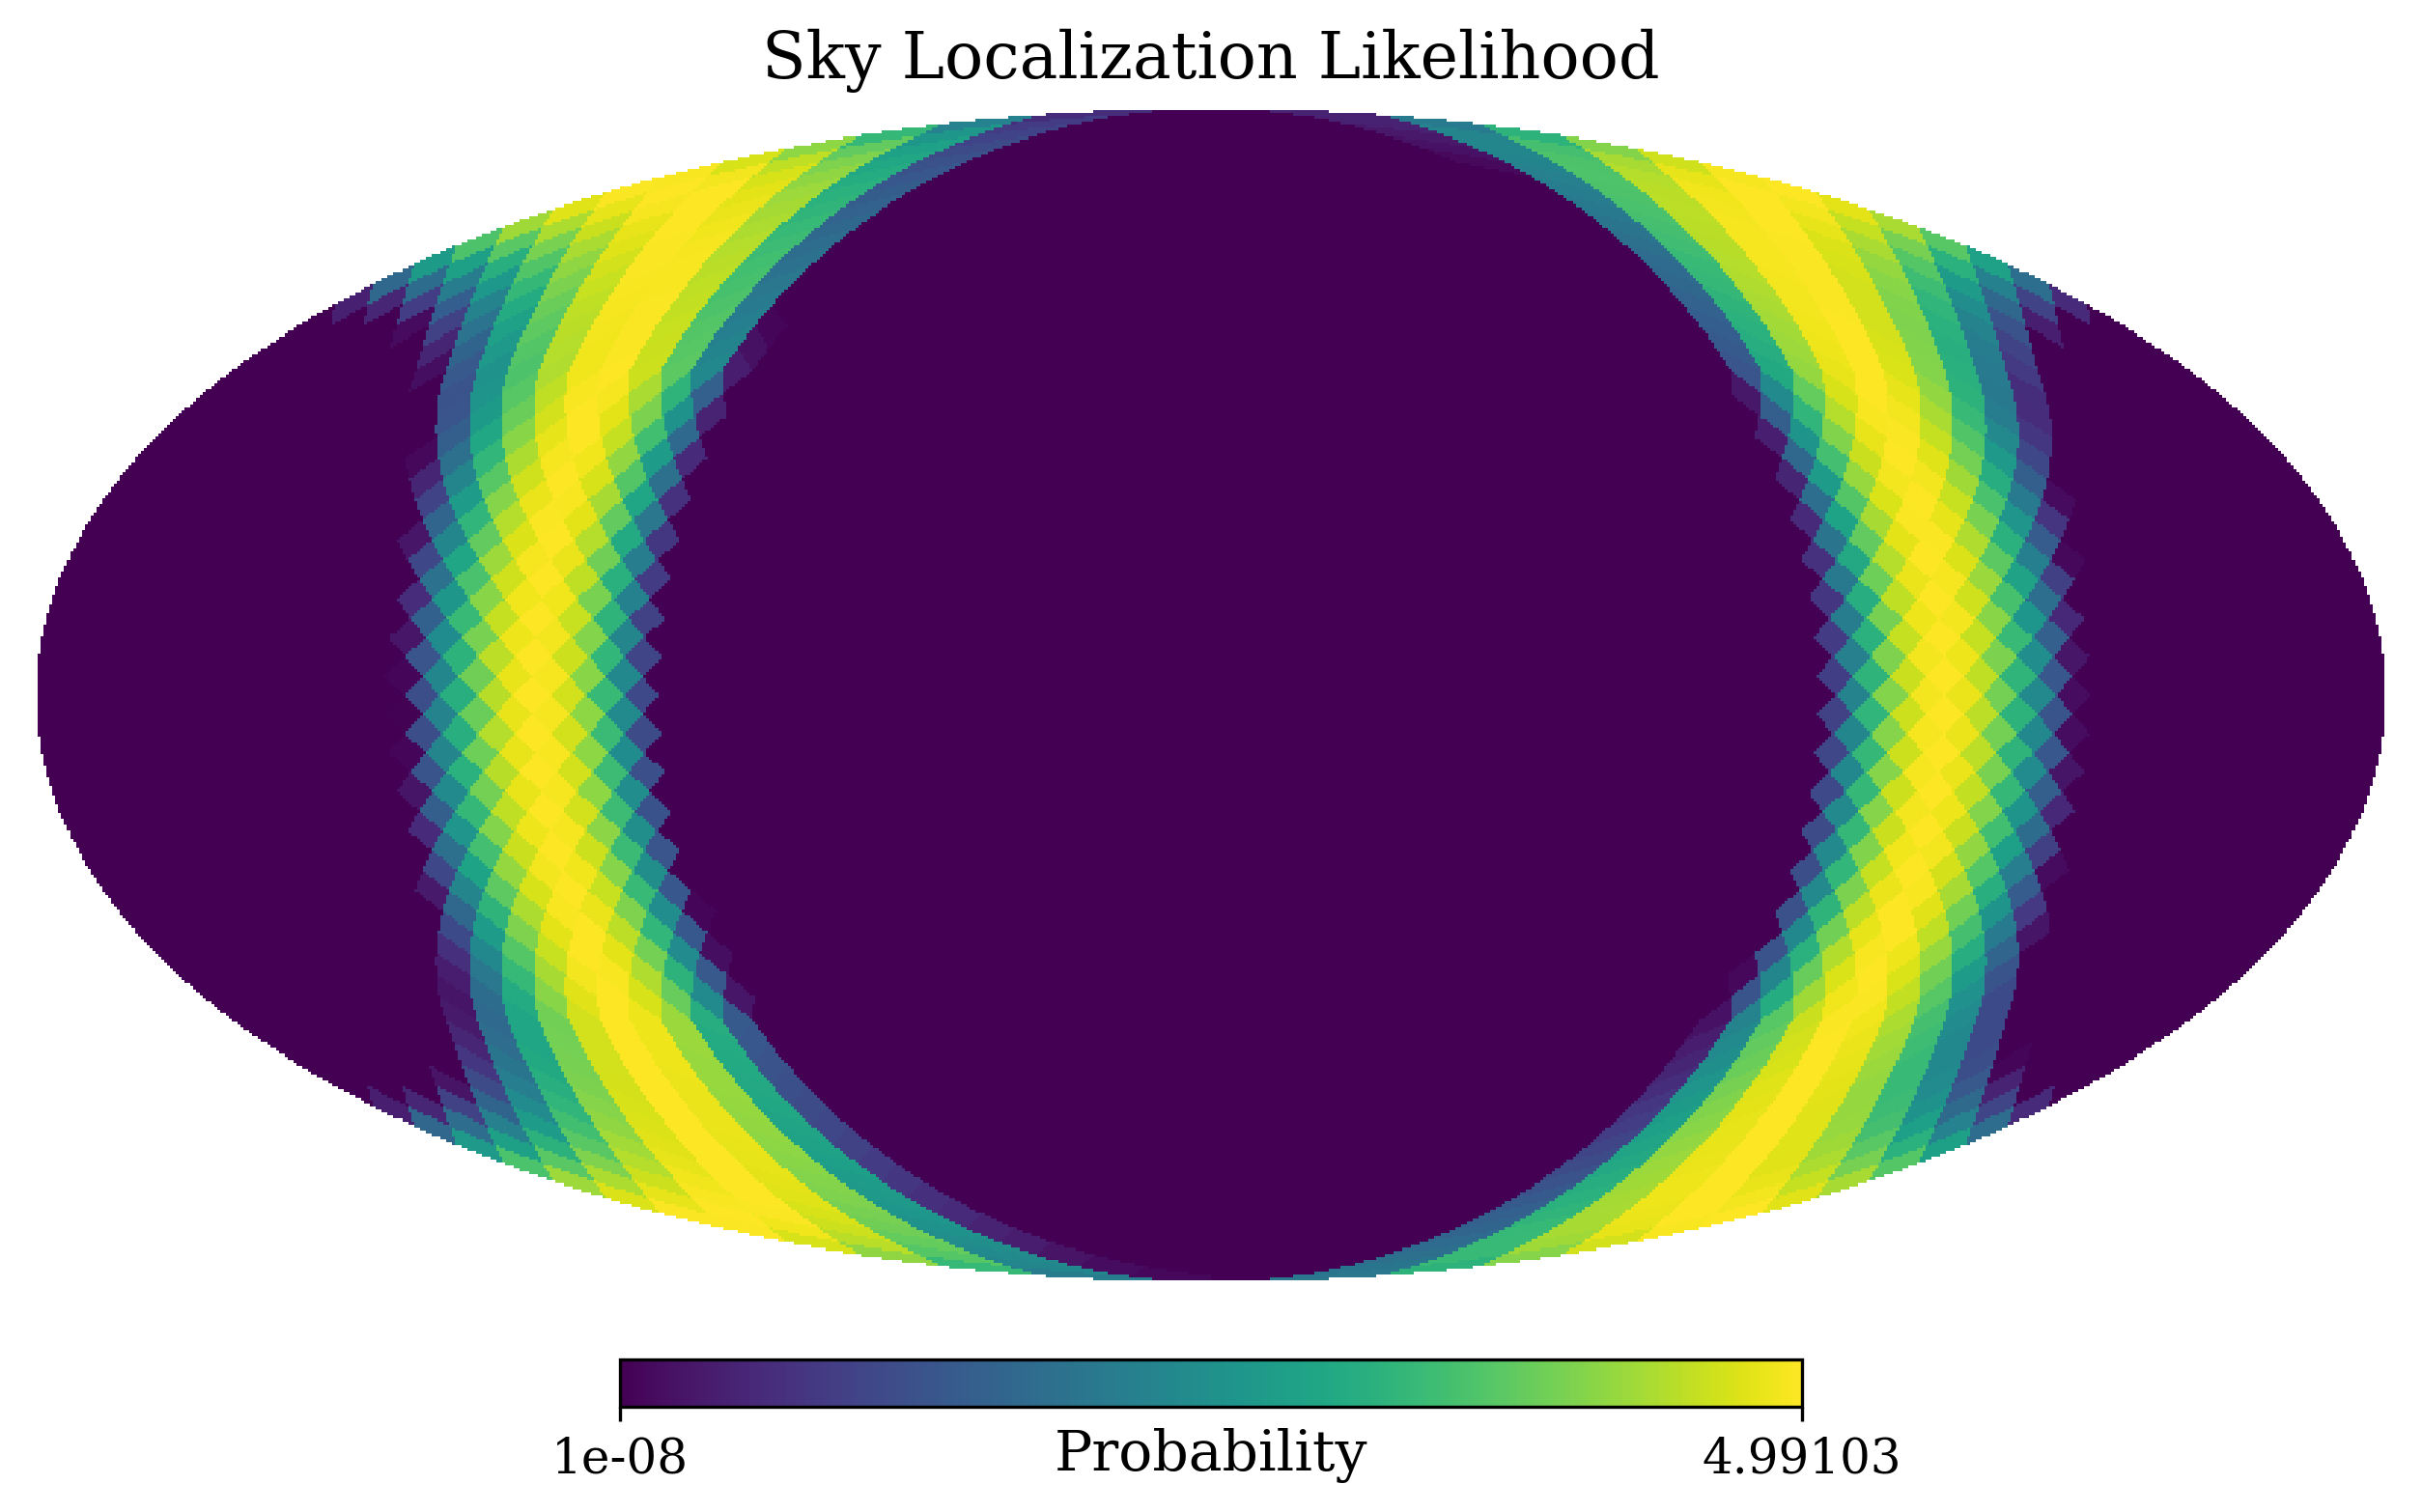

: 

: 

: 

In [ ]:
# Example parameters
nside = 16
detectors_choice = ['V1', 'H1']
arrival_times_in = [V1_time_max_snr, H1_time_max_snr]
arrival_time_uncert_in = [V1_time_uncertainty, H1_time_uncertainty]

# Generate map
prob_map = generate_likelihood_skymap(nside, detectors=detectors_choice, arrival_times = arrival_times_in, arrival_time_uncert = arrival_time_uncert_in, gps_start_time = gps_start_time)
# Plot the probability map
hp.mollview(prob_map, title='Sky Localization Likelihood', unit='Probability',
            cmap='viridis', min=1e-8)
plt.show()